In [1]:
### ALLOW FRACTIONAL SHARES!!! ###

## TO DO:
1) Adjust the existing indicators as reccomended in the NOTES ✔
2) Play with the arbitrary values set in some of the indicators ✔\
    a) create_sequences ✔\
    b) create_obv_indicator ✔\
    c) adx_indicators ✔\
    d) assess_macd_divergence ✔
3) Add more data/indicators as features ✔
4) Alter the models ✔\
    a) Alter which model analyses the data vs analyses the error ✔\
    b) add new models ✔\
    c) Alter hyperparameters (especially in the RF) ✔
5) Alter the buy/sell signals and trading strategy ✔
6) Find historical option data and use that in conjunction with the buy/sell signals\
    a) Alternatively, use a leveraged fund like SPXL ✔\
\
COMPLETED: 09/16/2024
____________________________________________________________________________________________
NEW LIST: 09/18/2024\
NOTE: The full model stack is already fairly accurate (see corr. + model metrics). To optomize the model further, the buy and sell signals, as well as the compiled strategy must be altered.

1) Ensure there is no further data leakage\
    a) training set does not cross into testing\
    b) features do not overlap\
        1. Combine or eliminate features that tell the same story
2) If overfitting is a concern:\
    a) Adjusted the models in the stack to compensate, or remove models to reduce complexity\
    b) Increase the sample size by reducing the sequence length \
    c) Reduce the sequence overlap
3) Optomize the run speed with parallel processing/delay 
4) Create one cohesive script that can be run from a single line with input parameters\
    a) Allow the user to skip specific trainings, or all trainings, and input their own CSV file
       if they have one to skip the predictions/signal generation step. Also allow them to input specific trading parameters rather than forcing a search.
5) Alter the buy and sell signals \
    a) Play around with the dynamic signals -- maybe stray from using quartiles\
    b) Revert back to a binary buy/sell and compare the results
6) Alter the trading strategies\
    a) Play with the dynamic buy/sell fractions\
    b) Attempt to get the max down draw threshold down to below 40% (without losing major gains)\
    c) Switch what fund is traded (maybe other leveraged funds can be utilized)
7) Alter the underlying for all training (currently using SPY)\
    a) Allow the user to select the stock they want the models to train on\
    b) Allow the user to select the stock they want the strategy to trade on

In [2]:
# Necessary imports
from IPython.display import display
import yfinance as yf
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import logging
from datetime import datetime, timedelta
import pandas_market_calendars as mcal

# For the LSTM + GRU + CNN models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.regularizers import l2
from keras.layers import BatchNormalization
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For the meta regressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline

In [3]:
# Note, everything is worded as SPXL because that was the initial ticker i used to trade with,
# but altering this will alter the trading ticker.
trading_ticker = 'SPXL'

# The ticker used to train all of the AI models.. Can be the same as the trading ticker, but i used
# SPY to train and SPXL to trade initially
training_ticker = 'SPY'

# Allowing fractional shares. Some brokerages do not allow fractional trading.
fractional_shares = True

In [4]:
# sequence length is the number of continuous days presented as single units the models will train on.
# See create_sequences for more details
seq_length = 45
# forecast horizon is the number of days the model will predict into the future.
# eg. a sequence length amount of feature data will be provided, and a forecast horizon amount of 
# days will be predicted.
forecast_horizon = 15

# Used for the backtest... Arbitrary number, but also it does not trade in partial shares, so you need
# to use a large enough account to trade the ticker you selected. 
# YOU MUST RUN THE BACKTEST WITH THIS AMOUNT! OPTIMAL CONDITIONS ARE DEPENDENT UPON YOUR STARTING
initial_balance = 10000

In [5]:
# Current list of features used throughout the document -- constantly changing
binary_trinary_features = ['OBV_Indicator', 'Divergence', 'Trend_Confirmation', 
                           'MACD_Crossover', 'MACD_Divergence', '50_200_SMA_Cross', 
                           '12_26_EMA_Cross', '50_200_EMA_Cross', 'Trend_Strength',
                           'MFI_Signal', 'Stochastic_Signal', 'All_volume_weighted_Signal',
                          'RSI_ROC_Signal', 'CCI_Aroon_Signal']

# Combining the binary with the continuous features. Continuous features will be normalized.
all_features = binary_trinary_features + ['Open', 'High', 'Low', 'Close', 'Volume']

In [6]:
# Callbacks used in several of the models. More callbacks can be added with ease.
# Look for *Callbacks to find all locations these are used.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [7]:
# Define the hyperparameter distributions

# Base model 1: aka the 'loaded_model'
lstm_gru_param_dist = {
    'model__lstm_units': [50, 64, 128],
    'model__gru_units': [50, 64, 128],
    'model__dropout_rate': [0.1, 0.2, 0.3, 0.5],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32, 64],
    'epochs': [50]
}

# Base model 2: aka the cnn_lstm_model
cnn_lstm_param_dist = {
    'model__filters': [32, 64, 128],
    'model__kernel_size': [2, 3, 4],
    'model__lstm_units': [50, 64, 128],
    'model__dropout_rate': [0.1, 0.2, 0.3, 0.5],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32, 64],
    'epochs': [50]
}

# Error model distribution for both base models
ann_error_param_dist = {
    'model__neurons': [5, 10, 20, 30, 40, 50],
    'model__layers': [1, 2, 3, 4],
    'batch_size': [10, 20, 40, 60, 80, 100],
    'epochs': [50, 100, 150, 200],
    'optimizer': ['adam', 'rmsprop'],
}

# Meta regressor parameter grid
# (base model 1 + ANN_1) stacked with (base model 2 + ANN_2)
meta_param_grid = [
    {
        'model': [Ridge()],
        'model__alpha': [0.1, 1.0, 10.0, 100.0],
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    {
        'model': [Lasso()],
        'model__alpha': [0.1, 1.0, 10.0, 100.0],
        'model__max_iter': [1000, 5000, 10000]
    },
    {
        'model': [LinearRegression()],
        'model__fit_intercept': [True, False],
        'model__copy_X': [True, False],
        'model__positive': [True, False]
    }
]

In [8]:
class StockDataProcessor:
    '''
    When the run all function 'get_data' is run:
    Retrieves stock historical data and appends several metrics and associated derivative indicators.
    Can also be used to independently append indicators.
    '''
    def __init__(self):
        self.df = None

    def get_stock_data(self, ticker):
        '''
        Retrieves the stock data using yfinance, and storing it as a pandas df
        '''
        # Retrieving the data
        stock_data = yf.download(ticker)
        # Reformatting as a DF
        df = pd.DataFrame(stock_data)
        # Returning the resulting DF
        return df

    def calculate_rsi(self, df, window=14):
        '''
        Calculates the relative strength index
        '''
        # Calculate the difference in closing prices
        # computes the difference between the current closing price and the previous closing price 
        # for each day.
        delta = df['Close'].diff()
        # Separate the gains and losses.
        # gain: This line keeps only the positive differences (gains) and replaces negative differences 
        # with 0. Then, it calculates the rolling mean of these gains over the specified window.
        # loss: This line keeps only the negative differences (losses), converts them to positive values, 
        # and replaces positive differences with 0. Then, it calculates the rolling mean of these losses over the specified window.
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        # Calculate the relative strength.
        rs = gain / loss
        # Calculate RSI and add it as a new column
        df['RSI'] = 100 - (100 / (1 + rs))
        # Return the df
        return df

    def rsi_signal(self, df):
        '''
        1 = Overbought (RSI > 70)
        0 = Neither (RSI = 30 - 70)
        -1 = Oversold (RSI < 30)
        '''
        df['RSI_Signal'] = 0
        df.loc[df['RSI'] > 70, 'RSI_Signal'] = 1
        df.loc[df['RSI'] < 30, 'RSI_Signal'] = -1
        return df

    def calculate_obv(self, df):
        '''
        Calculates On-Balance Volume values
        '''
        # df['Close'].diff() = daily price change
        # np.sign(df['Close'].diff()) = determine the direction of price change (returns 1, 0, or -1)
        # np.sign(df['Close'].diff()) * df['Volume'] = multiplying by the volume
        # .fillna(0) handles missing values
        # .cumsum() = cummulative sum
        df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
        return df

    def create_obv_indicator(self, df):
        '''
        Uses the OBV values to create a trading indicator
        NOTE: Potentially update the indicator so that -1 represents an opposing direction of OBV and 
        Price, eg. price difference > 1/2 SD ABOVE, AND OBV difference > 1/2 SD BELOW.
        '''
        # Calculate the daily price and OBV change and make columns with that data
        df['Price_Change'] = df['Close'].diff()
        df['OBV_Change'] = df['OBV'].diff()

        # Find the standard deviation of the price and OBV change
        price_std = df['Price_Change'].std()
        obv_std = df['OBV_Change'].std()

        # Set thresholds for price and OBV changes (arbitrarily selected half of a SD)
        price_threshold = price_std / 2
        obv_threshold = obv_std / 2

        def indicator(row):
            '''
            0 = Both price and OBV change are within 1/2 of a SD
            1 = Both price and OBV change > 1/2 of a SD in the same direction
            -1 = Either price or OBV exceed 1/2 a SD, while the other does not.
            '''
            if abs(row['Price_Change']) <= price_threshold and abs(row['OBV_Change']) <= obv_threshold:
                return 0
            elif abs(row['Price_Change']) > price_threshold and abs(row['OBV_Change']) > obv_threshold:
                return 1
            else:
                return -1
        # Apply the indicator function to the OBV_Indicator column
        df['OBV_Indicator'] = df.apply(indicator, axis=1)
        return df

    def calculate_adx(self, df, window=14):
        '''
        Calculates the true range, directional momentum (positive and negative), directional indicators,
        Directional index, and the average of the DX values over the specified window
        '''
        high = df['High']
        low = df['Low']
        close = df['Close']
        # Calculate the true range
        df['TR'] = np.maximum(high - low, np.maximum(abs(high - close.shift()), abs(low - close.shift())))
        # Calculate directional movements
        # +DM = positive directional movement
        # -DM = Negative directional movement
        df['+DM'] = np.where((high - high.shift()) > (low.shift() - low), high - high.shift(), 0)
        df['-DM'] = np.where((low.shift() - low) > (high - high.shift()), low.shift() - low, 0)
        # Calculate directional indicators
        # +DI: Positive Directional Indicator, the smoothed +DM divided by the smoothed TR.
        # -DI: Negative Directional Indicator, the smoothed -DM divided by the smoothed TR.
        df['+DI'] = 100 * (df['+DM'].rolling(window=window).mean() / df['TR'].rolling(window=window).mean())
        df['-DI'] = 100 * (df['-DM'].rolling(window=window).mean() / df['TR'].rolling(window=window).mean())
        # Calculate the directional index
        # DX: Directional Index, the absolute difference between +DI and -DI divided by their sum.
        df['DX'] = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
        # Calculate the average directional index
        # ADX: The average of the DX values over the specified window, indicating the strength of the trend.
        df['ADX'] = df['DX'].rolling(window=window).mean()
        return df

    def adx_indicators(self, df):
        '''
        Uses the average directional movement to create trading indicators including:
        1) Trend Strength
        2) Trend Confirmation
        3) Divergence
        NOTE: Potentially alter the Binary changes (as of now they only count positive movements)
        NOTE2: Potentially alter divergence as it currently does not need both values opposing
        ''' 
        # Trend Strength
        # Binary outcome, 1 if ADX > 25, else 0
        df['Trend_Strength'] = np.where(df['ADX'] >= 25, 1, 0)

        # Trend Confirmation
        # Checks the closing prices over a rolling window of 5 periods.
        # 1 = closing prices are increasing every day over the window period
        # -1 = closing prices are falling every day
        # 0 = No clear trend -- neither falling or rising every day.
        df['Trend_Confirmation'] = df['Close'].rolling(window=5).apply(
            lambda x: 1 if all(x[i] < x[i+1] for i in range(len(x)-1)) else (-1 if all(x[i] > x[i+1] for i in range(len(x)-1)) else 0), 
            raw=True
        )

        # Binary Price Change
        # True = all prices are increasing in the window, else False
        df['Price_Change'] = df['Close'].rolling(window=5).apply(lambda x: all(x[i] < x[i+1] for i in range(len(x)-1)), raw=True).astype(bool)

        # Binary ADX Change
        # True = all ADX values are increasing in the window, else False
        df['ADX_Change'] = df['ADX'].rolling(window=5).apply(lambda x: all(x[i] < x[i+1] for i in range(len(x)-1)), raw=True).astype(bool)

        # Divergence
        # -1 = Prices increasing but ADX is not
        # 1 = Prices not increasing but ADX is
        # 0 = no divergence
        df['Divergence'] = df.apply(lambda row: -1 if row['Price_Change'] and not row['ADX_Change'] else (1 if not row['Price_Change'] and row['ADX_Change'] else 0), axis=1)

        return df

    def calculate_macd(self, df, short_window=12, long_window=26, signal_window=9):
        '''
        Calculates the Moving Average Convergence/Divergence (MACD) using the standard windows
        '''
        # Calculates the 12-period and 26-period exponential moving average. 
        # ewm() applies exponential weighting gives more weight to recent values and less weight to 
        # older values
        df['EMA12'] = df['Close'].ewm(span=short_window, adjust=False).mean()
        df['EMA26'] = df['Close'].ewm(span=long_window, adjust=False).mean()
        # Calculates the MACD signal by taking the exponential weighting of the difference between
        # the 12 and 26 day EMAs
        df['MACD'] = df['EMA12'] - df['EMA26']
        df['MACD_Signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
        return df

    def assess_macd_crossovers(self, df):
        '''
        Assesses MACD crossovers as indicators/signals
        1 = Bullish cross
        -1 = Bearish cross
        0 = No crossovers, neutral
        '''
        df = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
        df['MACD_Crossover'] = 0
        df.loc[(df['MACD'] > df['MACD_Signal']) & (df['MACD'].shift(1) <= df['MACD_Signal'].shift(1)), 'MACD_Crossover'] = 1
        df.loc[(df['MACD'] < df['MACD_Signal']) & (df['MACD'].shift(1) >= df['MACD_Signal'].shift(1)), 'MACD_Crossover'] = -1
        return df

    def assess_macd_divergence(self, df, n=3):
        '''
        Assesses MACD divergence
        1 = Bullish divergence
        -1 = Bearish divergence
        0 = No divergence, neutral
        '''
        # Initialize the MACD_Divergence list with zeros
        macd_divergence = [0] * len(df)
        # There must be n number of days of continuous divergence to count
        for i in range(n, len(df)):
            try:
                if all(df['Close'].iloc[i] > df['Close'].iloc[i-j] for j in range(1, n+1)) and all(df['MACD'].iloc[i] < df['MACD'].iloc[i-j] for j in range(1, n+1)):
                    macd_divergence[i] = -1
                elif all(df['Close'].iloc[i] < df['Close'].iloc[i-j] for j in range(1, n+1)) and all(df['MACD'].iloc[i] > df['MACD'].iloc[i-j] for j in range(1, n+1)):
                    macd_divergence[i] = 1
            except KeyError:
                continue
        return macd_divergence

    def calculate_roc(self, df, period=14):
        '''
        Calculate the Price Rate of Change (ROC) and generate bullish/bearish signals based on median thresholds.

        Parameters:
        df (DataFrame): DataFrame containing the stock price data.
        period (int): The period over which to calculate the ROC.

        Returns:
        DataFrame: DataFrame with ROC and ROC_Signal columns added.
        '''
        df['ROC'] = df['Close'].pct_change(periods=period) * 100

        # Calculate medians of positive and negative ROC values
        positive_median = df[df['ROC'] > 0]['ROC'].median()
        negative_median = df[df['ROC'] < 0]['ROC'].median()

        df['ROC_Signal'] = 0
        df.loc[df['ROC'] > positive_median, 'ROC_Signal'] = 1
        df.loc[df['ROC'] < negative_median, 'ROC_Signal'] = -1
        return df

    def calculate_vwap(self, df, n_days=3):
        '''
        Calculate the Volume Weighted Average Price (VWAP) and generate signals based on the closing price being above or below the VWAP for N consecutive days.

        Parameters:
        df (DataFrame): DataFrame containing the stock price data.
        n_days (int): The number of consecutive days the closing price must be above or below the VWAP to generate a signal.

        Returns:
        DataFrame: DataFrame with VWAP and VWAP_Signal columns added.
        '''
        df['VWAP'] = (df['Volume'] * (df['High'] + df['Low'] + df['Close']) / 3).cumsum() / df['Volume'].cumsum()

        # Initialize the signal column
        df['VWAP_Signal'] = 0

        # Check for the condition over a rolling window for bullish signals
        df['Above_VWAP'] = df['Close'] > df['VWAP']
        df['VWAP_Signal'] = df['Above_VWAP'].rolling(window=n_days).apply(lambda x: 1 if x.sum() == n_days else 0, raw=True)

        # Check for the condition over a rolling window for bearish signals
        df['Below_VWAP'] = df['Close'] < df['VWAP']
        df['VWAP_Signal'] = df['VWAP_Signal'] + df['Below_VWAP'].rolling(window=n_days).apply(lambda x: -1 if x.sum() == n_days else 0, raw=True)

        return df

    def calculate_wma(self, df, period=14, n_days=3):
        '''
        Calculate the Weighted Moving Average (WMA) and generate signals based on the closing price being above or below the WMA for N consecutive days.

        Parameters:
        df (DataFrame): DataFrame containing the stock price data.
        period (int): The period over which to calculate the WMA.
        n_days (int): The number of consecutive days the closing price must be above or below the WMA to generate a signal.

        Returns:
        DataFrame: DataFrame with WMA and WMA_Signal columns added.
        '''
        weights = np.arange(1, period + 1)
        df['WMA'] = df['Close'].rolling(period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)

        # Initialize the signal column
        df['WMA_Signal'] = 0

        # Check for the condition over a rolling window for bullish signals
        df['Above_WMA'] = df['Close'] > df['WMA']
        df['WMA_Signal'] = df['Above_WMA'].rolling(window=n_days).apply(lambda x: 1 if x.sum() == n_days else 0, raw=True)

        # Check for the condition over a rolling window for bearish signals
        df['Below_WMA'] = df['Close'] < df['WMA']
        df['WMA_Signal'] = df['WMA_Signal'] + df['Below_WMA'].rolling(window=n_days).apply(lambda x: -1 if x.sum() == n_days else 0, raw=True)

        return df

    def calculate_hma(self, df, period=14, n_days=3):
        '''
        Calculate the Hull Moving Average (HMA) and generate signals based on the closing price being above or below the HMA for N consecutive days.

        Parameters:
        df (DataFrame): DataFrame containing the stock price data.
        period (int): The period over which to calculate the HMA.
        n_days (int): The number of consecutive days the closing price must be above or below the HMA to generate a signal.

        Returns:
        DataFrame: DataFrame with HMA and HMA_Signal columns added.
        '''
        half_length = int(period / 2)
        sqrt_length = int(np.sqrt(period))

        # Calculate HMA
        df['HMA'] = 2 * df['Close'].rolling(half_length).mean() - df['Close'].rolling(period).mean()
        df['HMA'] = df['HMA'].rolling(sqrt_length).mean()

        # Initialize the signal column
        df['HMA_Signal'] = 0

        # Check for the condition over a rolling window for bullish signals
        df['Above_HMA'] = df['Close'] > df['HMA']
        df['HMA_Signal'] = df['Above_HMA'].rolling(window=n_days).apply(lambda x: 1 if x.sum() == n_days else 0, raw=True)

        # Check for the condition over a rolling window for bearish signals
        df['Below_HMA'] = df['Close'] < df['HMA']
        df['HMA_Signal'] = df['HMA_Signal'] + df['Below_HMA'].rolling(window=n_days).apply(lambda x: -1 if x.sum() == n_days else 0, raw=True)

        return df

    def calculate_cci(self, df, period=20):
        '''
        Commodity Channel Index (CCI)
        '''
        TP = (df['High'] + df['Low'] + df['Close']) / 3
        df['CCI'] = (TP - TP.rolling(period).mean()) / (0.015 * TP.rolling(period).std())
        df['CCI_Signal'] = 0
        df.loc[df['CCI'] > 100, 'CCI_Signal'] = 1
        df.loc[df['CCI'] < -100, 'CCI_Signal'] = -1
        return df

    def calculate_aroon(self, df, period=25, n_days=3):
        '''
        Calculate the Aroon Indicator and generate signals based on Aroon Up and Aroon Down values for N consecutive days.

        Parameters:
        df (DataFrame): DataFrame containing the stock price data.
        period (int): The period over which to calculate the Aroon indicator.
        n_days (int): The number of consecutive days the Aroon Up must be greater than Aroon Down (or vice versa) to generate a signal.

        Returns:
        DataFrame: DataFrame with Aroon_Up, Aroon_Down, and Aroon_Signal columns added.
        '''
        df['Aroon_Up'] = df['Close'].rolling(period).apply(lambda x: float(np.argmax(x) + 1) / period * 100, raw=True)
        df['Aroon_Down'] = df['Close'].rolling(period).apply(lambda x: float(np.argmin(x) + 1) / period * 100, raw=True)

        # Initialize the signal column
        df['Aroon_Signal'] = 0

        # Check for the condition over a rolling window for bullish signals
        df['Aroon_Up_Above'] = df['Aroon_Up'] > df['Aroon_Down']
        df['Aroon_Signal'] = df['Aroon_Up_Above'].rolling(window=n_days).apply(lambda x: 1 if x.sum() == n_days else 0, raw=True)

        # Check for the condition over a rolling window for bearish signals
        df['Aroon_Down_Above'] = df['Aroon_Up'] < df['Aroon_Down']
        df['Aroon_Signal'] = df['Aroon_Signal'] + df['Aroon_Down_Above'].rolling(window=n_days).apply(lambda x: -1 if x.sum() == n_days else 0, raw=True)

        return df

    def calculate_mfi(self, df, period=14):
        '''
        Money Flow Index (MFI)
        '''
        TP = (df['High'] + df['Low'] + df['Close']) / 3
        MF = TP * df['Volume']
        df['MFI'] = 100 - (100 / (1 + (MF.rolling(period).sum() / MF.rolling(period).sum().shift(1))))
        df['MFI_Signal'] = 0
        df.loc[df['MFI'] > 80, 'MFI_Signal'] = 1
        df.loc[df['MFI'] < 20, 'MFI_Signal'] = -1
        return df

    def calculate_stochastic(self, df, period=14, n_days=5):
        '''
        Calculate the Stochastic Oscillator and generate signals based on %K and %D values for N consecutive days.

        Parameters:
        df (DataFrame): DataFrame containing the stock price data.
        period (int): The period over which to calculate the Stochastic Oscillator.
        n_days (int): The number of consecutive days the %K must be greater than %D (or vice versa) to generate a signal.

        Returns:
        DataFrame: DataFrame with %K, %D, and Stochastic_Signal columns added.
        '''
        df['L14'] = df['Low'].rolling(window=period).min()
        df['H14'] = df['High'].rolling(window=period).max()
        df['%K'] = 100 * ((df['Close'] - df['L14']) / (df['H14'] - df['L14']))
        df['%D'] = df['%K'].rolling(window=3).mean()

        # Initialize the signal column
        df['Stochastic_Signal'] = 0

        # Check for the condition over a rolling window for bullish signals
        df['%K_Above_%D'] = df['%K'] > df['%D']
        df['Stochastic_Signal'] = df['%K_Above_%D'].rolling(window=n_days).apply(lambda x: 1 if x.sum() == n_days else 0, raw=True)

        # Check for the condition over a rolling window for bearish signals
        df['%K_Below_%D'] = df['%K'] < df['%D']
        df['Stochastic_Signal'] = df['Stochastic_Signal'] + df['%K_Below_%D'].rolling(window=n_days).apply(lambda x: -1 if x.sum() == n_days else 0, raw=True)

        return df

    def calculate_sma(self, df, window):
        '''
        Calculates a simple moving average over a given input window
        '''
        df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
        return df

    def calculate_ema(self, df, window):
        '''
        Calculates an exponential moving average over a given input window
        '''
        df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()
        return df

    def calculate_cross(self, df, short_col, long_col, cross_col):
        '''
        1 = Short-term moving average crossed above the long-term
        0 = No crosses
        -1 = Short-term moving average crossed below the long-term
        '''
        # Initilize the cross column
        df[cross_col] = 0
        df.loc[(df[short_col] > df[long_col]) & (df[short_col].shift(1) <= df[long_col].shift(1)), cross_col] = 1
        df.loc[(df[short_col] < df[long_col]) & (df[short_col].shift(1) >= df[long_col].shift(1)), cross_col] = -1
        return df

    def combine_signals(self, df):
        """
        Add combined signal columns to the DataFrame based on various technical indicators.

        Parameters:
        df (DataFrame): DataFrame containing the stock price data and individual signal columns.

        Returns:
        DataFrame: DataFrame with additional combined signal columns.
        """
        # Add combined volume-weighted signals
        df['All_volume_weighted_Signal'] = df.apply(lambda row: 1 if all(row[signal] == 1 for signal in ['VWAP_Signal', 'WMA_Signal', 'HMA_Signal'])
                                                    else -1 if all(row[signal] == -1 for signal in ['VWAP_Signal', 'WMA_Signal', 'HMA_Signal'])
                                                    else 0, axis=1)

        # Add combined RSI and ROC signals
        df['RSI_ROC_Signal'] = df.apply(lambda row: 1 if all(row[signal] == 1 for signal in ['RSI_Signal', 'ROC_Signal'])
                                        else -1 if all(row[signal] == -1 for signal in ['RSI_Signal', 'ROC_Signal'])
                                        else 0, axis=1)

        # Add combined CCI and Aroon signals
        df['CCI_Aroon_Signal'] = df.apply(lambda row: 1 if all(row[signal] == 1 for signal in ['CCI_Signal', 'Aroon_Signal'])
                                          else -1 if all(row[signal] == -1 for signal in ['CCI_Signal', 'Aroon_Signal'])
                                          else 0, axis=1)

        return df

    def get_data(self):
        '''
        Combines all of the indicators above into a single df, then combines several to reduce 
        model complexity and avoid several overlapping features
        '''
        # ticker = input("Enter the ticker symbol: ")
        ticker = training_ticker
        self.df = self.get_stock_data(ticker)
        self.df = self.calculate_rsi(self.df)
        self.df = self.rsi_signal(self.df)
        self.df = self.calculate_obv(self.df)
        self.df = self.create_obv_indicator(self.df)
        self.df = self.calculate_adx(self.df)
        self.df = self.adx_indicators(self.df)
        self.df = self.calculate_macd(self.df)
        self.df = self.assess_macd_crossovers(self.df)
        self.df['MACD_Divergence'] = self.assess_macd_divergence(self.df, n=3)
        self.df = self.calculate_roc(self.df)
        self.df = self.calculate_vwap(self.df)
        self.df = self.calculate_wma(self.df)
        self.df = self.calculate_hma(self.df)
        self.df = self.calculate_cci(self.df)
        self.df = self.calculate_aroon(self.df)
        self.df = self.calculate_mfi(self.df)
        self.df = self.calculate_stochastic(self.df)
        self.df = self.calculate_sma(self.df, 50)
        self.df = self.calculate_sma(self.df, 200)
        self.df = self.calculate_ema(self.df, 12)
        self.df = self.calculate_ema(self.df, 26)
        self.df = self.calculate_ema(self.df, 50)
        self.df = self.calculate_ema(self.df, 200)

        # Calculate SMA and EMA crosses
        self.df = self.calculate_cross(self.df, 'SMA_50', 'SMA_200', '50_200_SMA_Cross')
        self.df = self.calculate_cross(self.df, 'EMA_12', 'EMA_26', '12_26_EMA_Cross')
        self.df = self.calculate_cross(self.df, 'EMA_50', 'EMA_200', '50_200_EMA_Cross')
        
        # Combine signals for feature reduction in the future
        self.df = self.combine_signals(self.df)
        return self.df


In [9]:
class DataPreprocessor:
    '''
    Prepare the data for training by: 
    1) removing NaN values caused by some indicators
    2) splitting the data into training and validation sets
    3) normalizing continuous data
    4) splitting the data into sequences for training
    '''
    def __init__(self, train_size=0.8, seq_length=seq_length, forecast_horizon=forecast_horizon, shift=15):
        self.train_size = train_size
        self.seq_length = seq_length
        self.forecast_horizon = forecast_horizon
        self.shift = shift
        self.close_scaler = None

    def preprocess_data(self, df):
        '''
        Preprocessing the data by normalizing the long integer columns.
        Returns the updated df, the closing price scaler (for reverse transformation later),
        all the features (just in case i need that later), and data (values for all the columns
        included in all_features)
        '''
        # Creating a copy of the df, and selecting all but the first 200 records (200 day SMA has nan)
        df_copy = df.copy()
        df_copy = df_copy[201:]
        
        # Retain only the important features for training
        df_copy = df_copy[all_features]
        
        # Calculate the split index
        split_index = int(len(df_copy) * self.train_size)
        
        # Split the data into training and test sets based on the split index
        train_df = df_copy.iloc[:split_index]
        test_df = df_copy.iloc[split_index:]
        
        # Initialize the scaler
        scaler = MinMaxScaler(feature_range=(0, 1))

        # List of columns to normalize
        columns_to_normalize = ['Open', 'High', 'Low', 'Volume']

        # Normalize the 'Close' column separately
        self.close_scaler = MinMaxScaler(feature_range=(0, 1))
        train_df.loc[:, 'Close'] = self.close_scaler.fit_transform(train_df[['Close']])
        test_df.loc[:, 'Close'] = self.close_scaler.transform(test_df[['Close']])

        # Normalize the other columns
        train_df.loc[:, columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])
        test_df.loc[:, columns_to_normalize] = scaler.transform(test_df[columns_to_normalize])
        
        return train_df, test_df, self.close_scaler

    def create_sequences(self, data, close_data):
        '''
        Creates sequences of data and separates the features (X) from the outcome (stock forecast) (y). 
        Sequences can then be split into training and validation sets.
        Sequences are shifted by 15 day (3 trading weeks) increments to increase the sample size, but to
        hopefully avoid redundancy and overfitting from smaller shifts.
        '''
        X = []
        y = []
        i = self.seq_length
        while i < len(data) - self.forecast_horizon:
            X.append(data[i-self.seq_length:i])
            y.append(close_data[i:i+self.forecast_horizon])  # Predict a sequence of future prices
            i += self.shift  # Shift the window by the specified number of days
        return np.array(X), np.array(y)


In [10]:
# The LSTM + GRU hybrid model (base model 1)
def create_LSTM_GRU_model(lstm_units=50, gru_units=50, dropout_rate=0.2, optimizer='adam', input_shape = 'None'):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(GRU(units=gru_units, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=forecast_horizon))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


In [11]:
# The CNN + LSTM hybrid model (base model 2)
def create_cnn_lstm_model(filters=64, kernel_size=3, lstm_units=50, dropout_rate=0.2, optimizer='adam', input_shape = None):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dense(units=forecast_horizon))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [12]:
# The ANN error models for both base model 1 and 2
def create_error_model(neurons=1, layers=1, dropout_rate=0.2, optimizer='adam', input_dim=None, dense_output_shape=None):
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_dim, kernel_initializer='uniform', activation='relu', kernel_regularizer=l2(0.01)))
    for _ in range(layers - 1):
        model.add(Dense(neurons, kernel_initializer='uniform', activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(dense_output_shape, kernel_initializer='uniform'))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


In [13]:
class StackedEnsemblePredictor:
    '''
    Retrieves preprocessed data and trained the full ensemble stack.
    Outputs some useful metrics to indicate full model performance.
    '''
    def __init__(self, train_size=0.8, seq_length=seq_length, forecast_horizon=forecast_horizon, shift=15):
        self.close_scaler = None
        self.loaded_model = None
        self.CNN_LSTM_BASE = None
        self.best_model_loaded = None
        self.best_model_CNN_LSTM = None
        self.meta_model = None
        # Instantiate the StockDataProcessor
        self.data_processor = StockDataProcessor()
        # Instantiate the DataPreprocessor
        self.data_preprocessor = DataPreprocessor(train_size, seq_length, forecast_horizon, shift)

    def generate_test_train_data(self):
        '''
        Retrieves and preprocesses data for training
        '''
        # Fetching the data
        # df = get_data()
        df = self.data_processor.get_data()

        # Preprocess the data
        train_df, test_df, self.close_scaler = self.data_preprocessor.preprocess_data(df)

        train_data = train_df
        test_data = test_df
        train_close_data = train_df['Close'].values
        test_close_data = test_df['Close'].values

        # Create sequences for training and test sets
        X_train, y_train = self.data_preprocessor.create_sequences(train_data, train_close_data)
        X_test, y_test = self.data_preprocessor.create_sequences(test_data, test_close_data)

        
        return df.copy(), X_train, y_train, X_test, y_test, self.close_scaler
    
    def train_LSTM_GRU(self, X_train, y_train, *callbacks):
        '''
        Trains the LSTM + GRU hybrid model (base model 1) using a grid search.
        Saves the trained model with the best hyperparameters as a pkl file.
        '''
        input_shape = (X_train.shape[1], X_train.shape[2])
    
        # Wrap the model using KerasRegressor
        model = KerasRegressor(build_fn=create_LSTM_GRU_model, input_shape=input_shape, verbose=2)

        # Define the hyperparameters to search
        param_dist = lstm_gru_param_dist

        # Set up the grid search with cross-validation
        grid_search = GridSearchCV(estimator=model, param_grid=param_dist, 
                                   cv=3, verbose=2, n_jobs=-1)

        # Fit the grid search model with callbacks
        grid_search_result = grid_search.fit(X_train, y_train, callbacks=list(callbacks))

        # Print the best parameters and score
        print(f"Best: {grid_search_result.best_score_} using {grid_search_result.best_params_}")

        # Save the model
        joblib.dump(grid_search_result, 'LSTM_GRU_BASE.pkl')

        return grid_search_result

    def train_CNN_LSTM_model(self, X_train, y_train, *callbacks):
        '''
        Trains the CNN + LSTM hybrid model (base model 2) using a grid search.
        Saves the trained model with the best hyperparameters as a pkl file.
        '''
        input_shape = (X_train.shape[1], X_train.shape[2])

        # Wrap the model using KerasRegressor
        model = KerasRegressor(build_fn=create_cnn_lstm_model, input_shape=input_shape, verbose=2)

        # Define the hyperparameters to search
        param_dist = cnn_lstm_param_dist

        # Set up the grid search with cross-validation
        grid_search = GridSearchCV(estimator=model, param_grid=param_dist, 
                                   cv=3, verbose=2, n_jobs=-1)

        # Fit the grid search model with callbacks
        grid_search_result = grid_search.fit(X_train, y_train, callbacks=list(callbacks))

        # Print the best parameters and score
        print(f"Best: {grid_search_result.best_score_} using {grid_search_result.best_params_}")

        # Save the model
        joblib.dump(grid_search_result, 'CNN_LSTM_BASE.pkl')

        return grid_search_result

    def error_preprocessing(self, loaded_model, CNN_LSTM_BASE, X_train, y_train, X_test, y_test):
        '''
        Uses the base models to make predictions, then calculates the errors by comparing to the 
        real values (y_train/test), and finally flattens the errors for use in the ANN models.
        '''
        # Generate predictions
        preds_loaded_model_train = loaded_model.predict(X_train)
        preds_loaded_model_test = loaded_model.predict(X_test)
        preds_CNN_LSTM_BASE_train = CNN_LSTM_BASE.predict(X_train)
        preds_CNN_LSTM_BASE_test = CNN_LSTM_BASE.predict(X_test)

        # Calculate errors
        errors_loaded_model_train = y_train - preds_loaded_model_train
        errors_loaded_model_test = y_test - preds_loaded_model_test
        errors_CNN_LSTM_BASE_train = y_train - preds_CNN_LSTM_BASE_train
        errors_CNN_LSTM_BASE_test = y_test - preds_CNN_LSTM_BASE_test

        # Flatten the errors
        errors_loaded_model_train_flat = errors_loaded_model_train.reshape(errors_loaded_model_train.shape[0], -1)
        errors_loaded_model_test_flat = errors_loaded_model_test.reshape(errors_loaded_model_test.shape[0], -1)
        errors_CNN_LSTM_BASE_train_flat = errors_CNN_LSTM_BASE_train.reshape(errors_CNN_LSTM_BASE_train.shape[0], -1)
        errors_CNN_LSTM_BASE_test_flat = errors_CNN_LSTM_BASE_test.reshape(errors_CNN_LSTM_BASE_test.shape[0], -1)

        return preds_loaded_model_train, preds_loaded_model_test, preds_CNN_LSTM_BASE_train, preds_CNN_LSTM_BASE_test, errors_loaded_model_train_flat, errors_loaded_model_test_flat, errors_CNN_LSTM_BASE_train_flat, errors_CNN_LSTM_BASE_test_flat

    def train_error_models(self, errors_loaded_model_train_flat, errors_CNN_LSTM_BASE_train_flat, y_train, *callbacks, skip_loaded_model=False, skip_CNN_LSTM_BASE=False):
        '''
        Trains the ANN error models for both base models (unless instucted to skip one/both) 
        using a random search.
        Saves the trained models with the best hyperparameters as pkl files.
        '''
        input_dim = errors_loaded_model_train_flat.shape[1]
        dense_output_shape = y_train.shape[1]

        best_model_loaded = None
        best_model_CNN_LSTM = None

        if not skip_loaded_model:
            # Wrap the model using KerasRegressor
            model = KerasRegressor(model=create_error_model, verbose=2, input_dim=input_dim, dense_output_shape=dense_output_shape)

            # Define the grid of hyperparameters to search
            param_dist = ann_error_param_dist

            ### Perform random search for LSTM_GRU_BASE errors ###
            random_search_loaded = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, n_jobs=-1)
            random_search_loaded_result = random_search_loaded.fit(errors_loaded_model_train_flat, y_train, callbacks=list(callbacks))

            # Save the best parameters for loaded_model
            Error_ANN_loaded_model = random_search_loaded_result.best_params_

            # Train the final model with the best parameters for loaded_model
            best_model_loaded = random_search_loaded_result.best_estimator_
            best_model_loaded.fit(errors_loaded_model_train_flat, y_train)

            # Save the best model for loaded_model
            joblib.dump(best_model_loaded, 'Error_ANN_loaded_model.pkl')
        else:
            best_model_loaded = joblib.load('Error_ANN_loaded_model.pkl')

        if not skip_CNN_LSTM_BASE:
            # Wrap the model using KerasRegressor
            model = KerasRegressor(model=create_error_model, verbose=2, input_dim=input_dim, dense_output_shape=dense_output_shape)

            # Define the grid of hyperparameters to search
            param_dist = ann_error_param_dist

            ### Perform random search for CNN_LSTM_BASE errors ###
            random_search_CNN_LSTM = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=30, cv=3, verbose=2, n_jobs=-1)
            random_search_CNN_LSTM_result = random_search_CNN_LSTM.fit(errors_CNN_LSTM_BASE_train_flat, y_train, callbacks=list(callbacks))

            # Save the best parameters for CNN_LSTM_BASE
            Error_ANN_CNN_LSTM_BASE = random_search_CNN_LSTM_result.best_params_

            # Train the final model with the best parameters for CNN_LSTM_BASE
            best_model_CNN_LSTM = random_search_CNN_LSTM_result.best_estimator_
            best_model_CNN_LSTM.fit(errors_CNN_LSTM_BASE_train_flat, y_train)

            # Save the best model for CNN_LSTM_BASE
            joblib.dump(best_model_CNN_LSTM, 'Error_ANN_CNN_LSTM_BASE.pkl')
        else:
            best_model_CNN_LSTM = joblib.load('Error_ANN_CNN_LSTM_BASE.pkl')

        return best_model_loaded, best_model_CNN_LSTM

    def meta_preprocess(self, best_model_loaded, best_model_CNN_LSTM, errors_loaded_model_train_flat, errors_loaded_model_test_flat, errors_CNN_LSTM_BASE_train_flat, errors_CNN_LSTM_BASE_test_flat, preds_loaded_model_train, preds_loaded_model_test, preds_CNN_LSTM_BASE_train, preds_CNN_LSTM_BASE_test):
        '''
        Preprocesses the data to prepare to train the meta model.
        Generates predictions with the ANN error models, and then combines the outputs with their 
        associated base models. The final predictions are then stacked for both training and test sets.
        '''
        # Generate predictions from the best models
        best_preds_loaded_model_train = best_model_loaded.predict(errors_loaded_model_train_flat)
        best_preds_loaded_model_test = best_model_loaded.predict(errors_loaded_model_test_flat)
        best_preds_CNN_LSTM_BASE_train = best_model_CNN_LSTM.predict(errors_CNN_LSTM_BASE_train_flat)
        best_preds_CNN_LSTM_BASE_test = best_model_CNN_LSTM.predict(errors_CNN_LSTM_BASE_test_flat)

        # Combine the predictions
        final_predictions_loaded_model_train = preds_loaded_model_train + best_preds_loaded_model_train
        final_predictions_loaded_model_test = preds_loaded_model_test + best_preds_loaded_model_test
        final_predictions_CNN_LSTM_BASE_train = preds_CNN_LSTM_BASE_train + best_preds_CNN_LSTM_BASE_train
        final_predictions_CNN_LSTM_BASE_test = preds_CNN_LSTM_BASE_test + best_preds_CNN_LSTM_BASE_test

        # Stack the combined predictions for the meta regressor
        combined_train_preds = np.column_stack((final_predictions_loaded_model_train, final_predictions_CNN_LSTM_BASE_train))
        combined_test_preds = np.column_stack((final_predictions_loaded_model_test, final_predictions_CNN_LSTM_BASE_test))

        return combined_train_preds, combined_test_preds
    
    def train_meta(self, combined_train_preds, combined_test_preds, y_train):
        '''
        Trains the final meta model on the preprocessed combined predictions of both base models and
        their ANN error models. Produces the FINAL predictions.
        '''
        # Define the pipeline
        pipeline = Pipeline([
            ('model', Ridge())  # Placeholder, will be replaced in the grid search
        ])

        # Set up the grid search with cross-validation
        grid_search = GridSearchCV(estimator=pipeline, param_grid=meta_param_grid, cv=3, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')

        # Fit the grid search to the combined training predictions
        grid_search.fit(combined_train_preds, y_train)

        # Print the best parameters and the corresponding score
        print(f'Best parameters found: {grid_search.best_params_}')
        print(f'Best cross-validation score: {-grid_search.best_score_}')

        # Use the best estimator to make final predictions
        meta_model = grid_search.best_estimator_

        # Generate final predictions
        final_train_preds = meta_model.predict(combined_train_preds)
        final_test_preds = meta_model.predict(combined_test_preds)

        # Save the meta_model
        joblib.dump(meta_model, 'meta_model.pkl')

        return final_train_preds, final_test_preds, meta_model
    
    def reverse_normalize(self, close_scaler, y_test, final_test_preds, y_train, final_train_preds):
        '''
        Reverses the normalization applied to the close value so that real values are observed.
        '''
        y_test_real = close_scaler.inverse_transform(y_test)
        final_predictions = close_scaler.inverse_transform(final_test_preds)
        y_train_real = close_scaler.inverse_transform(y_train)
        train_predictions_real = close_scaler.inverse_transform(final_train_preds)

        return y_test_real, final_predictions, y_train_real, train_predictions_real

    def calculate_metrics(self, y_train_real, train_predictions_real, y_test_real, final_predictions):
        '''
        Calculates some metrics to evaluate model performance on the train vs test sets.
        '''
        # Calculate metrics
        mae_train = mean_absolute_error(y_train_real, train_predictions_real)
        mae_test = mean_absolute_error(y_test_real, final_predictions)

        mse_train = mean_squared_error(y_train_real, train_predictions_real)
        mse_test = mean_squared_error(y_test_real, final_predictions)

        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)

        r2_train = r2_score(y_train_real, train_predictions_real)
        r2_test = r2_score(y_test_real, final_predictions)

        # Create a DataFrame to display the metrics
        metrics = {
            'Metric': ['MAE', 'RMSE', 'R²', 'MSE'],
            'Training Data': [mae_train, rmse_train, r2_train, mse_train],
            'Test Data': [mae_test, rmse_test, r2_test, mse_test]
        }

        metrics_df = pd.DataFrame(metrics)

        # Move the 'Metric' column to the index
        metrics_df.set_index('Metric', inplace=True)

        return metrics_df

    def calculate_gains_losses(self, final_predictions, X_test, close_scaler):
        '''
        Identify prediction movements to set more optimal buy and sell signals.
        '''
        # Convert X_test to a usable format by selecting only the closing prices from the features
        # and then inversing the normalization
        X_test_closing = X_test[:, :, -2]
        X_test_closing_real = close_scaler.inverse_transform(X_test_closing)

        # Extract the last closing price from each 45-day sequence
        last_closing_prices = X_test_closing_real[:, -1]

        # Calculate the percent change for each day in the 15-day predictions
        percent_changes = (final_predictions - last_closing_prices[:, np.newaxis]) / last_closing_prices[:, np.newaxis] * 100

        # Determine the maximum gain and loss for each 15-day prediction
        max_gains = np.max(percent_changes, axis=1)
        max_losses = np.min(percent_changes, axis=1)

        # Calculate the average maximum gain and loss across all predictions
        average_max_gain = np.mean(max_gains)
        average_max_loss = np.mean(max_losses)

        # Calculate the bottom quartile (Q1) and upper quartile (Q3) for gains and losses
        bottom_quartile_gain = np.percentile(max_gains, 25)
        upper_quartile_gain = np.percentile(max_gains, 75)
        bottom_quartile_loss = np.percentile(max_losses, 25)
        upper_quartile_loss = np.percentile(max_losses, 75)

        # Calculate the average percent change using absolute values
        average_percent_change = np.mean(np.abs(percent_changes))

        # Create a DataFrame to store the results
        results_df = pd.DataFrame({
            "Metric": ["Average Maximum", "Bottom Quartile", "Upper Quartile", "Average Percent Change"],
            "Positive (%)": [average_max_gain, bottom_quartile_gain, upper_quartile_gain, average_percent_change],
            "Negative (%)": [average_max_loss, bottom_quartile_loss, upper_quartile_loss, average_percent_change]
        })

        # Move the 'Metric' column to the index
        results_df.set_index('Metric', inplace=True)

        return results_df

    def calculate_accuracy_metrics(self, final_predictions, X_test, y_test, close_scaler):
        '''
        Check to see how accurate my predictions were to also assist in the buy/sell signal setting
        '''
        # Convert X_test to a usable format by selecting only the closing prices from the features
        # and then inversing the normalization
        X_test_closing = X_test[:, :, -2]
        X_test_closing_real = close_scaler.inverse_transform(X_test_closing)

        # Convert y_test to a usable format by inversing the normalization
        y_test_real = close_scaler.inverse_transform(y_test)

        # Extract the last closing price from each 45-day sequence
        last_closing_prices = X_test_closing_real[:, -1]

        # Calculate the percent change for each day in the 15-day predictions
        percent_changes_pred = (final_predictions - last_closing_prices[:, np.newaxis]) / last_closing_prices[:, np.newaxis] * 100
        percent_changes_true = (y_test_real - last_closing_prices[:, np.newaxis]) / last_closing_prices[:, np.newaxis] * 100

        # Calculate the mean percent change
        mean_percent_change_pred = np.mean(percent_changes_pred, axis=1)
        mean_percent_change_true = np.mean(percent_changes_true, axis=1)

        # Initialize arrays to store the final percent changes
        final_percent_change_pred = np.zeros(mean_percent_change_pred.shape)
        final_percent_change_true = np.zeros(mean_percent_change_true.shape)

        # Calculate the final percent change based on the mean percent change
        for i in range(len(mean_percent_change_pred)):
            if mean_percent_change_pred[i] > 0:
                final_percent_change_pred[i] = np.max(percent_changes_pred[i])
            else:
                final_percent_change_pred[i] = np.min(percent_changes_pred[i])

            if mean_percent_change_true[i] > 0:
                final_percent_change_true[i] = np.max(percent_changes_true[i])
            else:
                final_percent_change_true[i] = np.min(percent_changes_true[i])
        
        # Calculate the average percent change using absolute values
        average_percent_change_pred = np.mean(np.abs(final_percent_change_pred))
        average_percent_change_true = np.mean(np.abs(final_percent_change_true))

        # Determine the maximum gain and loss for each 15-day prediction
        max_gains_pred = np.max(final_percent_change_pred)
        max_losses_pred = np.min(final_percent_change_pred)
        max_gains_true = np.max(final_percent_change_true)
        max_losses_true = np.min(final_percent_change_true)

        # Calculate the bottom quartile (Q1) and upper quartile (Q3) for gains and losses
        bottom_quartile_gain_pred = np.percentile(final_percent_change_pred, 25)
        upper_quartile_gain_pred = np.percentile(final_percent_change_pred, 75)
        bottom_quartile_loss_pred = np.percentile(final_percent_change_pred, 25)
        upper_quartile_loss_pred = np.percentile(final_percent_change_pred, 75)

        bottom_quartile_gain_true = np.percentile(final_percent_change_true, 25)
        upper_quartile_gain_true = np.percentile(final_percent_change_true, 75)
        bottom_quartile_loss_true = np.percentile(final_percent_change_true, 25)
        upper_quartile_loss_true = np.percentile(final_percent_change_true, 75)

        # Calculate how often the price increased when it was predicted to increase within 50% proximity
        increase_accuracy_proximity = np.mean((final_percent_change_pred > 0) & (final_percent_change_true > 0) & 
                                              (final_percent_change_true >= 0.5 * final_percent_change_pred)) * 100

        # Calculate how often the price decreased when it was predicted to decrease within 75% proximity
        decrease_accuracy_proximity = np.mean((final_percent_change_pred < 0) & (final_percent_change_true < 0) & 
                                              (final_percent_change_true <= 0.5 * final_percent_change_pred)) * 100

        # Calculate general accuracy without proximity
        increase_accuracy_general = np.mean((final_percent_change_pred > 0) & (final_percent_change_true > 0)) * 100
        decrease_accuracy_general = np.mean((final_percent_change_pred < 0) & (final_percent_change_true < 0)) * 100

        # Create a DataFrame to store the results in two columns
        results_df = pd.DataFrame({
            "Metric": ["Average Maximum", "Bottom Quartile", "Upper Quartile", "Average Percent Change"],
            "Predicted Positive (%)": [np.mean(max_gains_pred), bottom_quartile_gain_pred, upper_quartile_gain_pred, average_percent_change_pred],
            "True Positive (%)": [np.mean(max_gains_true), bottom_quartile_gain_true, upper_quartile_gain_true, average_percent_change_true],
            "Predicted Negative (%)": [np.mean(max_losses_pred), bottom_quartile_loss_pred, upper_quartile_loss_pred, average_percent_change_pred],
            "True Negative (%)": [np.mean(max_losses_true), bottom_quartile_loss_true, upper_quartile_loss_true, average_percent_change_true]
        })

        results_df.set_index('Metric', inplace=True)

        
        pred_true_df = pd.DataFrame({
            'predicted': final_percent_change_pred,
            'true': final_percent_change_true
        })
        
        TP = ((pred_true_df['predicted'] > 0) & (pred_true_df['true'] > 0)).sum()
        TN = ((pred_true_df['predicted'] < 0) & (pred_true_df['true'] < 0)).sum()
        FP = ((pred_true_df['predicted'] > 0) & (pred_true_df['true'] < 0)).sum()
        FN = ((pred_true_df['predicted'] < 0) & (pred_true_df['true'] > 0)).sum()

        # Create the contingency table
        contingency_table = pd.DataFrame({
            'Predicted Positive': [TP, FP],
            'Predicted Negative': [FN, TN]
        }, index=['True Positive', 'True Negative'])
        
                # Extract values from the DataFrame
        TP = contingency_table.loc['True Positive', 'Predicted Positive']
        FP = contingency_table.loc['True Positive', 'Predicted Negative']
        FN = contingency_table.loc['True Negative', 'Predicted Positive']
        TN = contingency_table.loc['True Negative', 'Predicted Negative']

        # Calculate metrics
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        precision = TP / (TP + FP)
        npv = TN / (TN + FN)
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

        # Create a DataFrame to store the metrics with Metric as the index
        metrics_data = {
            'Value': [sensitivity, specificity, precision, npv, accuracy, f1_score]
        }
        metrics_df = pd.DataFrame(metrics_data, index=['Sensitivity (Recall)', 'Specificity', 'Precision', 'Negative Predictive Value (NPV)', 'Accuracy', 'F1 Score'])

        return results_df, contingency_table, pred_true_df, metrics_df
    
    def sample_plot(self, y_test_real, final_predictions):
        '''
        Selects a random sample of 4 true and predicted 15-day forecasts and plots them side-by-side
        '''
        # Randomly select 4 sample indices
        sample_indices = np.random.choice(y_test_real.shape[0], 4, replace=False)

        # Create a range for the x-axis (days)
        days = np.arange(1, (forecast_horizon+1))

        # Plotting the actual vs. predicted prices for multiple samples
        plt.figure(figsize=(12, 8))
        for sample_index in sample_indices:
            y_true_sample = y_test_real[sample_index]
            y_pred_sample = final_predictions[sample_index]

            # Ensure the selected sample has the correct shape
            if y_true_sample.shape != (forecast_horizon,) or y_pred_sample.shape != (forecast_horizon,):
                raise ValueError(f"Selected sample must have shape ({forecast_horizon},)")

            plt.plot(days, y_true_sample, label=f'Actual Prices (Sample {sample_index})', marker='o')
            plt.plot(days, y_pred_sample, label=f'Predicted Prices (Sample {sample_index})', marker='x')

        plt.xlabel('Day')
        plt.ylabel('Closing Price')
        plt.title(f'Actual vs. Predicted Stock Prices Over {str(forecast_horizon)} Days')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

    def run_full_model(self, skip_all=False, skip_loaded_model=False, skip_CNN_LSTM_BASE=False):
        '''
        Runs the full model. Retrieves and preprocesses data, trains and predicts values, and 
        outputs metrics to the assess model.
        '''
        df, X_train, y_train, X_test, y_test, self.close_scaler = self.generate_test_train_data()

        if not skip_all:
            if not skip_loaded_model:
                self.train_LSTM_GRU(X_train, y_train, early_stopping, reduce_lr)
                self.loaded_model = joblib.load('LSTM_GRU_BASE.pkl')
            else:
                self.loaded_model = joblib.load('LSTM_GRU_BASE.pkl')

            if not skip_CNN_LSTM_BASE:
                self.train_CNN_LSTM_model(X_train, y_train, early_stopping, reduce_lr)
                self.CNN_LSTM_BASE = joblib.load('CNN_LSTM_BASE.pkl')
            else:
                self.CNN_LSTM_BASE = joblib.load('CNN_LSTM_BASE.pkl')
        else:
            self.loaded_model = joblib.load('LSTM_GRU_BASE.pkl')
            self.CNN_LSTM_BASE = joblib.load('CNN_LSTM_BASE.pkl')

        preds_loaded_model_train, preds_loaded_model_test, preds_CNN_LSTM_BASE_train, preds_CNN_LSTM_BASE_test, errors_loaded_model_train_flat, errors_loaded_model_test_flat, errors_CNN_LSTM_BASE_train_flat, errors_CNN_LSTM_BASE_test_flat = self.error_preprocessing(self.loaded_model, self.CNN_LSTM_BASE, X_train, y_train, X_test, y_test)

        if not skip_all:
            self.best_model_loaded, self.best_model_CNN_LSTM = self.train_error_models(errors_loaded_model_train_flat, errors_CNN_LSTM_BASE_train_flat, y_train, early_stopping, reduce_lr, skip_loaded_model=skip_loaded_model, skip_CNN_LSTM_BASE=skip_CNN_LSTM_BASE)
        else:
            self.best_model_loaded = joblib.load('Error_ANN_loaded_model.pkl')
            self.best_model_CNN_LSTM = joblib.load('Error_ANN_CNN_LSTM_BASE.pkl')

        combined_train_preds, combined_test_preds = self.meta_preprocess(self.best_model_loaded, self.best_model_CNN_LSTM, errors_loaded_model_train_flat, errors_loaded_model_test_flat, errors_CNN_LSTM_BASE_train_flat, errors_CNN_LSTM_BASE_test_flat, preds_loaded_model_train, preds_loaded_model_test, preds_CNN_LSTM_BASE_train, preds_CNN_LSTM_BASE_test)

        if not skip_all:
            final_train_preds, final_test_preds, self.meta_model = self.train_meta(combined_train_preds, combined_test_preds, y_train)
        else:
            self.meta_model = joblib.load('META_MODEL.pkl')
            final_train_preds = self.meta_model.predict(combined_train_preds)
            final_test_preds = self.meta_model.predict(combined_test_preds)
        
        y_test_real, final_predictions, y_train_real, train_predictions_real = self.reverse_normalize(self.close_scaler, y_test, final_test_preds, y_train, final_train_preds)
        
        metrics = self.calculate_metrics(y_train_real, train_predictions_real, y_test_real, final_predictions)
        
        results = self.calculate_gains_losses(final_predictions, X_test, self.close_scaler)
        
        results_df, contingency_table, pred_true_df, metrics_df = self.calculate_accuracy_metrics(final_predictions, X_test, y_test, self.close_scaler)
        
        return df, metrics, results_df, contingency_table, results, self.close_scaler, y_test_real, final_predictions, pred_true_df, metrics_df


In [14]:
def pred_v_true_corr_plot(pred_true_df):
    # Calculate Pearson's correlation
    pearson_corr = pred_true_df['predicted'].corr(pred_true_df['true'], method='pearson')

    # Calculate Spearman's rank correlation
    spearman_corr = pred_true_df['predicted'].corr(pred_true_df['true'], method='spearman')

    # Create the scatter plot
    plt.scatter(pred_true_df['predicted'], pred_true_df['true'])
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Scatter Plot of Predicted vs True Values')

    # Add the correlation values to the plot
    plt.text(0.05, 0.95, f'Pearson: {pearson_corr:.2f}\nSpearman: {spearman_corr:.2f}', 
             transform=plt.gca().transAxes, verticalalignment='top')

    # Calculate the regression line
    slope, intercept = np.polyfit(pred_true_df['predicted'], pred_true_df['true'], 1)
    plt.plot(pred_true_df['predicted'], slope * pred_true_df['predicted'] + intercept, color='blue', alpha=0.5)

    plt.show()

In [15]:
def get_pred_data(Prediction_df=None):
    '''
    Will take the last (sequence_length) days worth of features in a given input df and will predict
    the next (forecast_horizon) days worth of closing prices. If no df is input, the function will
    fetch the data and features for an input ticker. Ensure the ticker matches the trained models.
    '''
    # Enter some DF with the same columns/features as the training data
    if Prediction_df is None:
        data_processor = StockDataProcessor()
        Prediction_df = data_processor.get_data()
        Prediction_df = Prediction_df[all_features]
    
    # Test data (last seq_length days)
    Prediction_df_sequence = Prediction_df.copy()[-seq_length:]
    Prediction_df_sequence = Prediction_df_sequence[all_features]
    
    return Prediction_df_sequence

In [16]:
def normalize_dataframe(df):
    # Last known price to compare later:
    last_known_price = df['Close'][-1]
    # Initialize the scalers
    scaler = MinMaxScaler(feature_range=(0, 1))
    close_scaler = MinMaxScaler(feature_range=(0, 1))

    # List of columns to normalize
    columns_to_normalize = ['Open', 'High', 'Low', 'Volume']

    # Normalize the 'Close' column separately
    # df['Close'] = close_scaler.fit_transform(df[['Close']])
    df.loc[:, 'Close'] = close_scaler.fit_transform(df[['Close']])

    # Normalize the other columns
    # df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    df.loc[:, columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    return df, close_scaler, last_known_price

In [17]:
def reshape_dataframe(df, timesteps=seq_length):
    """

    """
    # Reset the index to ensure the data is purely numerical
    df_reset = df.reset_index(drop=True)
    
    # Convert the DataFrame to a NumPy array
    data_array = df_reset.values
    
    # Ensure the data has the correct shape
    if data_array.shape[0] != timesteps:
        raise ValueError(f"Data must have exactly {timesteps} rows to match the expected timesteps.")
    
    # Reshape the data to three dimensions
    reshaped_data = data_array.reshape((1, data_array.shape[0], data_array.shape[1]))
    
    return reshaped_data

In [18]:
def ensemble_predict(data, base_model1, base_model2, error_model1, error_model2, meta_model, close_scaler, timesteps=seq_length):
    # Predict on the data using the base models
    model1_predict = base_model1.predict(data)
    model2_predict = base_model2.predict(data)
    
    # Predict errors using the error models
    error1_predict = error_model1.predict(model1_predict)
    error2_predict = error_model2.predict(model2_predict)
    
    # Combine base model predictions with error predictions
    final_predictions_model1 = model1_predict + error1_predict
    final_predictions_model2 = model2_predict + error2_predict
    
    # Stack the combined predictions for the meta regressor
    combined_preds = np.column_stack((final_predictions_model1, final_predictions_model2))
    
    # Generate final predictions using the meta model
    final_prediction = meta_model.predict(combined_preds)
    
    # Inverse transform the predictions to get the actual prices
    final_prediction = close_scaler.inverse_transform(final_prediction.reshape(-1, 1))
    
    return final_prediction

In [19]:
def predict(df=None, timesteps=seq_length):
    if len(df) > seq_length:
        data = get_pred_data(df)
    else:
        data = df.copy()
    # Normalize the data
    normalized_df, close_scaler, last_known_price = normalize_dataframe(data)
    reshaped_data = reshape_dataframe(normalized_df, timesteps)
    LSTM_GRU_BASE = joblib.load('LSTM_GRU_BASE.pkl')
    CNN_LSTM_BASE = joblib.load('CNN_LSTM_BASE.pkl')
    Error_ANN_loaded_model = joblib.load('Error_ANN_loaded_model.pkl')
    Error_ANN_CNN_LSTM_BASE = joblib.load('Error_ANN_CNN_LSTM_BASE.pkl')
    meta_model = joblib.load('meta_model.pkl')
    # Convert the data to float32
    reshaped_data = reshaped_data.astype('float32')
    prediction = ensemble_predict(reshaped_data, LSTM_GRU_BASE, CNN_LSTM_BASE, Error_ANN_loaded_model, Error_ANN_CNN_LSTM_BASE, meta_model, close_scaler)
    
    return prediction, last_known_price

In [20]:
# Formerly generate_trade_signals
def generate_historical_predictions():
    # Retrieve the historical data
    data_processor = StockDataProcessor()
    historical_data = data_processor.get_data()
    # Retain only the trained upon columns
    historical_data = historical_data[all_features]
    # remove the nan values for 200 day SMA
    historical_data = historical_data[199:]
    
    # Initialize an empty list to store the calculated values
    calculated_values = []

    # Loop through the historical data to generate predictions and calculate values
    for i in range(200, len(historical_data) - seq_length):
        # Get the current window of data
        current_data = historical_data.copy().iloc[i:i+seq_length]

        # Predict the next forecast_horizon days
        p, last_known_price = predict(current_data)

        # Calculate the percent changes
        percent_changes = ((p - last_known_price) / last_known_price) * 100
        mean_percent_change = percent_changes.mean()

        # Determine the value to store based on the mean percent change
        if mean_percent_change > 0:
            value = round(percent_changes.max(), 2)
        else:
            value = round(percent_changes.min(), 2)

        # Append the calculated value to the list
        calculated_values.append(value)
            
    # Add the calculated values to the historical data
    # First 200 days are empty because there are no 200-day SMA/EMA
    historical_data['Calculated Value'] = [None] * (200 + seq_length) + calculated_values
    
    return historical_data

In [21]:
def generate_dynamic_signals(df, positive_quartiles, negative_quartiles):
    # Initialize an empty list to store the signals
    signals = []

    # Loop through the 'Calculated Value' column to generate signals
    for value in df['Calculated Value']:
        if value > positive_quartiles.loc[0.75][0]:
            signals.append(3)  # Strong buy
        elif value > positive_quartiles.loc[0.50][0]:
            signals.append(2)  # Moderate buy
        elif value > positive_quartiles.loc[0.25][0]:
            signals.append(1)  # Small buy
        elif value > negative_quartiles.loc[0.75][0]:
            signals.append(0)  # Hold
        elif value > negative_quartiles.loc[0.50][0]:
            signals.append(-1)  # Small sell
        elif value > negative_quartiles.loc[0.25][0]:
            signals.append(-2)  # Moderate sell
        else:
            signals.append(-3)  # Strong sell

    # Add the signals to the DataFrame
    df['Signal'] = signals
    
    return df

In [22]:
def calculate_max_drawdown(balances):
    peak = balances[0]
    max_drawdown = 0
    for balance in balances:
        if balance > peak:
            peak = balance
        drawdown = (balance - peak) / peak
        if drawdown < max_drawdown:
            max_drawdown = drawdown
    return max_drawdown

In [23]:
import time
import winsound
# SImple alert to let me know the backtest is complete
def fluctuating_beep(start_freq, end_freq, step, duration):
    # Increase frequency
    for freq in range(start_freq, end_freq, step):
        winsound.Beep(freq, duration)
        time.sleep(0.5)
    # Decrease frequency
    for freq in range(end_freq, start_freq, -step):
        winsound.Beep(freq, duration)
        time.sleep(0.5)
        
# Fluctuate beep frequency
start_frequency = 500  # Starting frequency in Hertz
end_frequency = 1500   # Ending frequency in Hertz
step_frequency = 100   # Frequency step in Hertz
beep_duration = 500    # Beep duration in milliseconds

In [24]:
def backtest_strategy(data, spxl_data, stop_loss, freeze_period, buy_fractions, sell_fractions, trailing_stop_loss, trailing_sell_fraction):
    logging.info("Starting backtest...")
    balance = initial_balance
    position = 0  # No initial position
    balances = []  # To store balance over time
    freeze_until = None  # To track freeze period
    trades = 0  # To count the number of trades
    trade_details = []  # To store trade details
    peak_balance = initial_balance  # Track the peak balance for trailing stop-loss
    
    for i in range(len(data)):
        current_date = data.index[i]
        
        # Check if we are in a freeze period
        if freeze_until and current_date <= freeze_until:
            balances.append(balance + (position * spxl_data['Close'].iloc[i]))
            continue
        
        # Calculate position equity
        position_equity = position * spxl_data['Close'].iloc[i]
        current_balance = balance + position_equity
        
        # Update peak balance for trailing stop-loss
        if current_balance > peak_balance:
            peak_balance = current_balance
        
        # Check for trailing stop-loss condition
        if current_balance < peak_balance * (1 - trailing_stop_loss):
            shares_to_sell = position * trailing_sell_fraction
            balance += shares_to_sell * spxl_data['Close'].iloc[i]
            position -= shares_to_sell
            trades += 1  # Count the trailing stop-loss trade
            trade_details.append((current_date, 'Trailing Stop-Loss', shares_to_sell, spxl_data['Close'].iloc[i]))
            logging.info(f"Trailing stop-loss triggered on {current_date}: Sold {shares_to_sell} shares at {spxl_data['Close'].iloc[i]}")
        
        # Check for regular stop-loss condition
        if i >= 10:  # Ensure we have at least 2 weeks of data (assuming daily data)
            two_weeks_ago = i - 10
            max_equity = max(position * spxl_data['Close'].iloc[two_weeks_ago:i])
            if position_equity < max_equity * (1 - stop_loss):
                shares_to_sell = position * 0.8
                balance += shares_to_sell * spxl_data['Close'].iloc[i]
                position -= shares_to_sell
                freeze_until = current_date + pd.Timedelta(days=freeze_period)
                trades += 1  # Count the stop-loss trade
                trade_details.append((current_date, 'Stop-Loss', shares_to_sell, spxl_data['Close'].iloc[i]))
                logging.info(f"Stop-loss triggered on {current_date}: Sold {shares_to_sell} shares at {spxl_data['Close'].iloc[i]}")
        
        # Execute buy/sell signals
        signal = data['Signal'].iloc[i]
        if signal > 0 and balance > 0:
            amount_to_invest = balance * buy_fractions[signal]
            if fractional_shares:
                shares_to_buy = amount_to_invest / spxl_data['Close'].iloc[i]
            else:
                shares_to_buy = amount_to_invest // spxl_data['Close'].iloc[i]
            position += shares_to_buy
            balance -= shares_to_buy * spxl_data['Close'].iloc[i]
            trades += 1  # Count the buy trade
            trade_details.append((current_date, 'Buy', shares_to_buy, spxl_data['Close'].iloc[i]))
            logging.info(f"Buy signal on {current_date}: Bought {shares_to_buy} shares at {spxl_data['Close'].iloc[i]}")
        elif signal < 0 and position > 0:
            shares_to_sell = position * sell_fractions[abs(signal)]
            balance += shares_to_sell * spxl_data['Close'].iloc[i]
            position -= shares_to_sell
            trades += 1  # Count the sell trade
            trade_details.append((current_date, 'Sell', shares_to_sell, spxl_data['Close'].iloc[i]))
            logging.info(f"Sell signal on {current_date}: Sold {shares_to_sell} shares at {spxl_data['Close'].iloc[i]}")
        
        balances.append(balance + (position * spxl_data['Close'].iloc[i]))
        
    logging.info("Backtest completed.")
    # Calculate additional performance metrics
    final_balance = balances[-1]
    buy_and_hold_return = (spxl_data['Close'].iloc[-1] / spxl_data['Close'].iloc[0]) * initial_balance
    sharpe_ratio = (pd.Series(balances).pct_change().mean() / pd.Series(balances).pct_change().std()) * (252**0.5)
    sortino_ratio = (pd.Series(balances).pct_change().mean() / pd.Series(balances).pct_change().apply(lambda x: min(0, x)).std()) * (252**0.5)
    
    return balances, trades, final_balance, buy_and_hold_return, sharpe_ratio, sortino_ratio, trade_details


In [25]:
def run_backtest(max_drawdown_threshold, historical_data_reindexed, spxl_data, stop_loss, freeze_period, buy_fraction, sell_fraction, trailing_stop_loss, trailing_sell_fraction):
    buy_fractions = {1: buy_fraction * 0.5, 2: buy_fraction, 3: buy_fraction * 1.5}
    sell_fractions = {1: sell_fraction * 0.5, 2: sell_fraction, 3: sell_fraction * 1.5}
    
    strategy_balances, trades, final_balance, buy_and_hold_return, sharpe_ratio, sortino_ratio, trade_details = backtest_strategy(
        historical_data_reindexed, spxl_data, stop_loss, freeze_period, buy_fractions, sell_fractions, trailing_stop_loss, trailing_sell_fraction)
    
    max_drawdown = calculate_max_drawdown(strategy_balances)
    if max_drawdown > max_drawdown_threshold:
        return (stop_loss, freeze_period, buy_fraction, sell_fraction, trailing_stop_loss, trailing_sell_fraction, final_balance, max_drawdown, trades, sharpe_ratio, sortino_ratio, trade_details)
    return None

In [26]:
def full_backtest(historical_data_reindexed, spxl_data, param_dict):

    # Define default ranges
    default_params = {
        'stop_loss_values': np.arange(0.16, 0.26, 0.02),
        'freeze_period_values': np.arange(7, 11, 1),
        'buy_fraction_values': np.arange(0.2, 0.44, 0.02),
        'sell_fraction_values': np.arange(0.02, 0.09, 0.02),
        'trailing_stop_loss_values': np.arange(0.02, 0.09, 0.02),
        'trailing_sell_fraction_values': np.arange(0.00, 0.04, 0.01)
    }

    # Update default values with user-provided values
    for key in default_params:
        if param_dict.get(key) is not None:
            default_params[key] = param_dict[key]

    # Extract values from the updated dictionary
    stop_loss_values = default_params['stop_loss_values']
    freeze_period_values = default_params['freeze_period_values']
    buy_fraction_values = default_params['buy_fraction_values']
    sell_fraction_values = default_params['sell_fraction_values']
    trailing_stop_loss_values = default_params['trailing_stop_loss_values']
    trailing_sell_fraction_values = default_params['trailing_sell_fraction_values']

    # Define max drawdown threshold
    max_drawdown_threshold = -0.55  # Example threshold of -55%

    # Store results
    results = Parallel(n_jobs=-1)(delayed(run_backtest)(max_drawdown_threshold, historical_data_reindexed, spxl_data, stop_loss, freeze_period, buy_fraction, sell_fraction, trailing_stop_loss, trailing_sell_fraction)
                                  for stop_loss in stop_loss_values
                                  for freeze_period in freeze_period_values
                                  for buy_fraction in buy_fraction_values
                                  for sell_fraction in sell_fraction_values
                                  for trailing_stop_loss in trailing_stop_loss_values
                                  for trailing_sell_fraction in trailing_sell_fraction_values)

    # Filter out None results
    results = [result for result in results if result is not None]

    return results

In [27]:
class FullAlgo:
    def __init__(self, param_dict=None):
        self.start_date = '2009-01-07'
        self.full_model = StackedEnsemblePredictor()
        self.param_dict = {
            'stop_loss_values': None,
            'freeze_period_values': None,
            'buy_fraction_values': None,
            'sell_fraction_values': None,
            'trailing_stop_loss_values': None,
            'trailing_sell_fraction_values': None
        }
        if param_dict is not None:
            self.param_dict.update(param_dict)
        self.historical_data_copy = None
        self.spxl_data = None
        self.results_df = None
        self.df = None
        self.metrics = None
        self.model_results_df = None
        self.contingency_table = None
        self.results = None
        self.close_scaler = None
        self.y_test_real = None
        self.final_predictions = None
        self.pred_true_df = None
        self.metrics_df = None
        self.p = None
        self.last_known_price = None
        self.historical_data = None
        self.historical_data_reindexed = None
        self.best_result = None
        self.spy_balances = None
        self.spxl_buy_hold_balances = None
        self.positive_quartiles = None
        self.negative_quartiles = None
        
    def train_models(self, skip_all=True):
        self.df, self.metrics, self.model_results_df, self.contingency_table, self.results, self.close_scaler, self.y_test_real, self.final_predictions, self.pred_true_df, self.metrics_df = self.full_model.run_full_model(skip_all=skip_all)
        
    def display_model_metrics(self):
        display(self.metrics)
        display(self.results_df)
        print("Results DataFrame:")
        display(self.model_results_df)
    
    def display_model_contingency(self):
        print("\nContingency Table:")
        display(self.contingency_table)

        # Pulling metrics from the contingency tabe
        display(self.metrics_df)
        
    def display_model_sample_plot(self):
        # Plotting a sample of the true v predicted values
        self.full_model.sample_plot(self.y_test_real, self.final_predictions)
        
    def plot_correlation(self):
        # Plotting predictions vs true values correlation
        pred_v_true_corr_plot(self.pred_true_df)
        
    def make_prediction(self):
        self.p, self.last_known_price = predict(self.df)
        low_end = round(((self.p.min() - self.last_known_price)/self.last_known_price)*100, 2)
        high_end = round(((self.p.max() - self.last_known_price)/self.last_known_price)*100, 2)
        average = round(((self.p.mean() - self.last_known_price)/self.last_known_price)*100, 2)

        print(f'From the current price of {round(self.last_known_price, 2)}:\nThe minimum predicted value sits {low_end}% away\nThe maximum predicted value sits {high_end}% away\nThe average predicted value sits {average}% away')
    
    def historical_predictions(self, path=None):
        if path == None:
            self.historical_data = generate_historical_predictions()
            # Backing up the historical data with signals, because it takes forever to run.
            self.historical_data_copy = self.historical_data.copy()
            self.historical_data_copy.to_csv('backtest_predictions.csv', index=True)
        else:
            self.historical_data_copy = pd.read_csv(path, index_col=0)
        
        positive_values = self.historical_data_copy[self.historical_data_copy['Calculated Value'] > 0]['Calculated Value']
        negative_values = self.historical_data_copy[self.historical_data_copy['Calculated Value'] < 0]['Calculated Value']
        # Quartiles for positive values
        self.positive_quartiles = pd.DataFrame(positive_values.quantile([0.25, 0.5, 0.75]))
        # Quartiles for negative values
        self.negative_quartiles = pd.DataFrame(negative_values.quantile([0.25, 0.5, 0.75]))
    
    def historical_predictions_quartiles(self):
        display(self.positive_quartiles)
        display(self.negative_quartiles)
        
    def generate_trade_signals(self):
        # Generate signals and append to the DataFrame
        self.historical_data_copy = generate_dynamic_signals(self.historical_data_copy, self.positive_quartiles, self.negative_quartiles)
        
    def historical_data_values(self):
        print(self.historical_data_copy['Signal'].value_counts())
        
    def backtest_preprocess(self, start_date='2009-01-07', ticker=trading_ticker):
        self.start_date = start_date

        # Fetch SPXL data
        self.spxl_data = yf.download(ticker, start=start_date, end=self.historical_data_copy.index[-1])

        # Convert the string dates in Historical_data_copy to match the date-time format of spxl data
        self.historical_data_copy.index = pd.to_datetime(self.historical_data_copy.index)

        # Align historical data with SPXL data
        self.historical_data_reindexed = self.historical_data_copy.copy().reindex(self.spxl_data.index)
        
    def backtest(self):
        # Initialize logging
        logging.basicConfig(filename='backtest_9_24_24.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

        self.results = full_backtest(self.historical_data_reindexed, self.spxl_data, self.param_dict)
        
    def backtest_best_params(self):
        # Convert results to DataFrame
        self.results_df = pd.DataFrame(self.results, columns=['Stop Loss', 'Freeze Period', 'Buy Fraction', 'Sell Fraction', 'Trailing Stop Loss', 'Trailing Sell Fraction', 'Final Balance', 'Max Drawdown', 'Trades', 'Sharpe Ratio', 'Sortino Ratio', 'Trade Details'])

        # Find the best combination
        if not self.results_df.empty:
            self.best_result = self.results_df.loc[self.results_df['Final Balance'].idxmax()]
            print("Best Stop Loss:", self.best_result['Stop Loss'])
            print("Best Freeze Period:", self.best_result['Freeze Period'])
            print("Best Buy Fraction:", self.best_result['Buy Fraction'])
            print("Best Sell Fraction:", self.best_result['Sell Fraction'])
            print("Best Trailing Stop Loss:", self.best_result['Trailing Stop Loss'])
            print("Best Trailing Sell Fraction:", self.best_result['Trailing Sell Fraction'])
            print("Final Balance:", self.best_result['Final Balance'])
            print("Max Drawdown:", self.best_result['Max Drawdown'])
            print("Number of Trades:", self.best_result['Trades'])
            print("Sharpe Ratio:", self.best_result['Sharpe Ratio'])
            print("Sortino Ratio:", self.best_result['Sortino Ratio'])
            
        else:
            print("No strategy met the max drawdown threshold.")
        
        # To store the best strat
        br = self.best_result
        return br
            
    def backtest_plot(self):
        if not self.results_df.empty:
            # Plot the best strategy
            best_strategy_balances, best_strategy_trades, _, _, _, _, _ = backtest_strategy(
                self.historical_data_reindexed, self.spxl_data, self.best_result['Stop Loss'], self.best_result['Freeze Period'], 
                {1: self.best_result['Buy Fraction'] * 0.5, 2: self.best_result['Buy Fraction'], 3: self.best_result['Buy Fraction'] * 1.5}, 
                {1: self.best_result['Sell Fraction'] * 0.5, 2: self.best_result['Sell Fraction'], 3: self.best_result['Sell Fraction'] * 1.5},
                self.best_result['Trailing Stop Loss'], self.best_result['Trailing Sell Fraction'])

            # Calculate SPY balance over time
            spy_data = yf.download(training_ticker, start=self.start_date, end=self.historical_data_reindexed.index[-1])
            spy_data = spy_data.reindex(self.spxl_data.index)
            initial_spy_price = spy_data['Close'].iloc[0]
            self.spy_balances = (spy_data['Close'] / initial_spy_price) * 10000

            # Calculate SPXL buy-and-hold balance over time
            initial_spxl_price = self.spxl_data['Close'].iloc[0]
            self.spxl_buy_hold_balances = (self.spxl_data['Close'] / initial_spxl_price) * 10000

            # Ensure no NaN values in SPY balances
            self.spy_balances = self.spy_balances.fillna(method='ffill').fillna(method='bfill')

            # Create subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

            # Plot strategy vs SPY and SPXL buy-and-hold performance
            ax1.plot(self.historical_data_reindexed.index, best_strategy_balances, label='Strategy Balance')
            ax1.plot(spy_data.index, self.spy_balances, label='SPY Balance', linestyle='--')
            ax1.plot(self.spxl_data.index, self.spxl_buy_hold_balances, label='SPXL Buy & Hold Balance', linestyle='-.')
            ax1.set_xlabel('Date')
            ax1.set_ylabel('Balance ($)')
            ax1.set_title('Strategy vs SPY and SPXL Buy & Hold Performance')
            ax1.legend()

            # Plot just the strategy balance
            ax2.plot(self.historical_data_reindexed.index, best_strategy_balances, label='Strategy Balance', color='blue')
            ax2.set_xlabel('Date')
            ax2.set_ylabel('Balance ($)')
            ax2.set_title('Strategy Performance')
            ax2.legend()

            plt.tight_layout()
            plt.show()
        else:
            print("No strategy met the max drawdown threshold.")
            
    def backtest_table(self):
        if not self.results_df.empty:
            # Calculate metrics for SPY and SPXL buy-and-hold
            spy_max_drawdown = calculate_max_drawdown(self.spy_balances)
            spxl_max_drawdown = calculate_max_drawdown(self.spxl_buy_hold_balances)
            
            # Calculate Sharpe ratios for SPY and SPXL buy-and-hold strategies
            spy_sharpe_ratio = (self.spy_balances.pct_change().mean() / self.spy_balances.pct_change().std()) * (252**0.5)
            spxl_sharpe_ratio = (self.spxl_buy_hold_balances.pct_change().mean() / self.spxl_buy_hold_balances.pct_change().std()) * (252**0.5)

            # Create a comparison table
            comparison_table = pd.DataFrame({
                'Strategy': ['Custom Strategy', 'SPY Buy & Hold', 'SPXL Buy & Hold'],
                'Starting Principal': [initial_balance, initial_balance, initial_balance],
                'Final Balance': [self.best_result['Final Balance'], self.spy_balances[-1], self.spxl_buy_hold_balances[-1]],
                'Max Drawdown': [self.best_result['Max Drawdown'], spy_max_drawdown, spxl_max_drawdown],
                'Sharpe Ratio': [self.best_result['Sharpe Ratio'], spy_sharpe_ratio, spxl_sharpe_ratio],
                'Sortino Ratio': [self.best_result['Sortino Ratio'], None, None]  # Sortino Ratio not calculated for SPY and SPXL
            })

            display(comparison_table)
        else:
            print("No strategy met the max drawdown threshold.")
            
    def get_all_variables(self, skip_all=True, path=None):
        self.train_models(skip_all)
        self.historical_predictions(path)
        self.generate_trade_signals()
        self.backtest_preprocess()
        self.backtest()

In [28]:
specific_params = {
    'stop_loss_values': [0.18],
    'freeze_period_values': [8],
    'trailing_sell_fraction_values': [0.0]
}

In [29]:
m = FullAlgo(specific_params)

In [30]:
# path = 'backtest_predictions.csv'
m.get_all_variables(path='backtest_predictions.csv')

[*********************100%***********************]  1 of 1 completed


26/26 - 0s - 15ms/step
7/7 - 0s - 5ms/step
26/26 - 0s - 8ms/step
7/7 - 0s - 3ms/step
5/5 - 0s - 6ms/step
2/2 - 0s - 5ms/step
6/6 - 0s - 6ms/step
2/2 - 0s - 5ms/step


[*********************100%***********************]  1 of 1 completed


In [31]:
m.display_model_metrics()

,Training Data,Test Data
Metric,,
MAE,1.492026,5.776032
RMSE,2.123751,8.052132
R²,0.998382,0.990625
MSE,4.510319,64.836823


None

Results DataFrame:


,Predicted Positive (%),True Positive (%),Predicted Negative (%),True Negative (%)
Metric,,,,
Average Maximum,5.518418,10.591026,-7.739186,-23.284820
Bottom Quartile,-4.217171,-3.659300,-4.217171,-3.659300
Upper Quartile,1.702317,3.967545,1.702317,3.967545
Average Percent Change,2.883230,4.275129,2.883230,4.275129


In [32]:
m.display_model_contingency()


Contingency Table:


,Predicted Positive,Predicted Negative
True Positive,56,9
True Negative,1,35


,Value
Sensitivity (Recall),0.982456
Specificity,0.795455
Precision,0.861538
Negative Predictive Value (NPV),0.972222
Accuracy,0.900990
F1 Score,0.918033


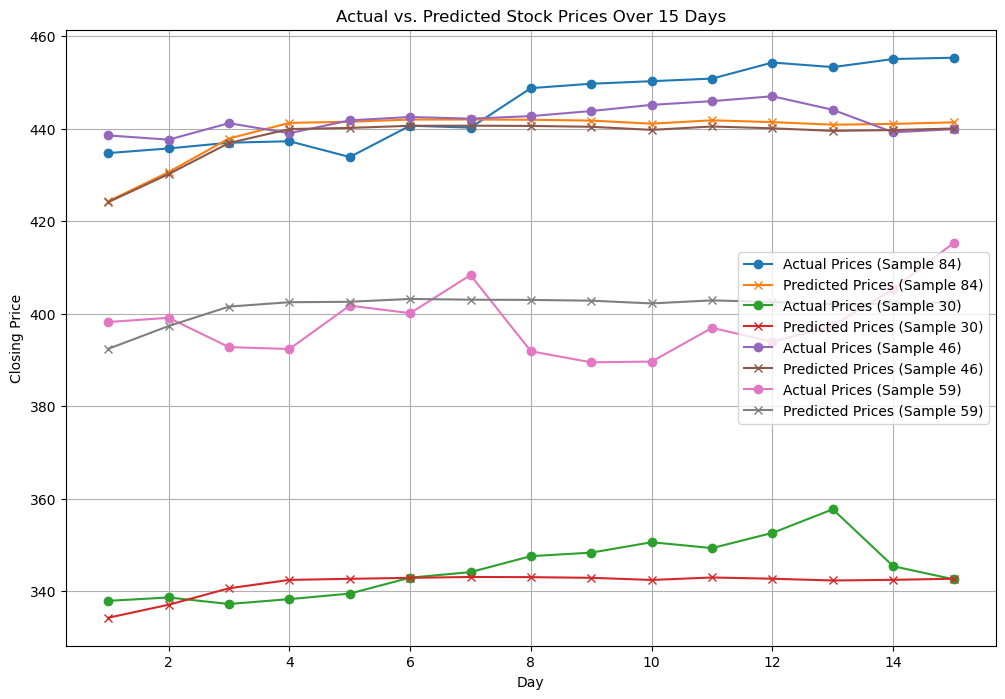

In [33]:
m.display_model_sample_plot()

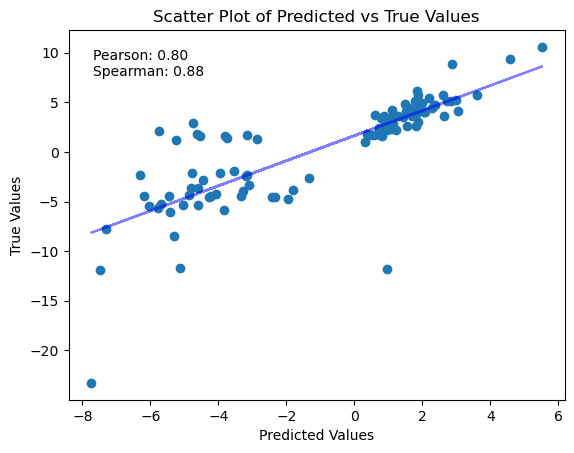

In [34]:
m.plot_correlation()

In [35]:
m.make_prediction()

1/1 - 0s - 266ms/step
1/1 - 0s - 87ms/step
1/1 - 0s - 31ms/step
1/1 - 0s - 46ms/step
From the current price of 598.19:
The minimum predicted value sits 0.94% away
The maximum predicted value sits 1.91% away
The average predicted value sits 1.76% away


In [36]:
m.historical_predictions_quartiles()

,Calculated Value
0.25,2.15
0.50,3.49
0.75,5.18


,Calculated Value
0.25,-1.14
0.50,-0.72
0.75,-0.43


In [37]:
m.historical_data_values()

Signal
 0    1880
 2    1795
 1    1790
 3    1789
-3     334
-2      92
-1      87
Name: count, dtype: int64


In [38]:
m.backtest_best_params()

Best Stop Loss: 0.18
Best Freeze Period: 8
Best Buy Fraction: 0.3999999999999999
Best Sell Fraction: 0.02
Best Trailing Stop Loss: 0.02
Best Trailing Sell Fraction: 0.0
Final Balance: 1009915.646820862
Max Drawdown: -0.5481434649554511
Number of Trades: 5448
Sharpe Ratio: 0.8776456215339346
Sortino Ratio: 1.3882112545174476


Stop Loss                                                              0.18
Freeze Period                                                             8
Buy Fraction                                                            0.4
Sell Fraction                                                          0.02
Trailing Stop Loss                                                     0.02
Trailing Sell Fraction                                                  0.0
Final Balance                                                1009915.646821
Max Drawdown                                                      -0.548143
Trades                                                                 5448
Sharpe Ratio                                                       0.877646
Sortino Ratio                                                      1.388211
Trade Details             [(2009-01-07 00:00:00, Buy, 1921.0247654083046...
Name: 160, dtype: object

[*********************100%***********************]  1 of 1 completed


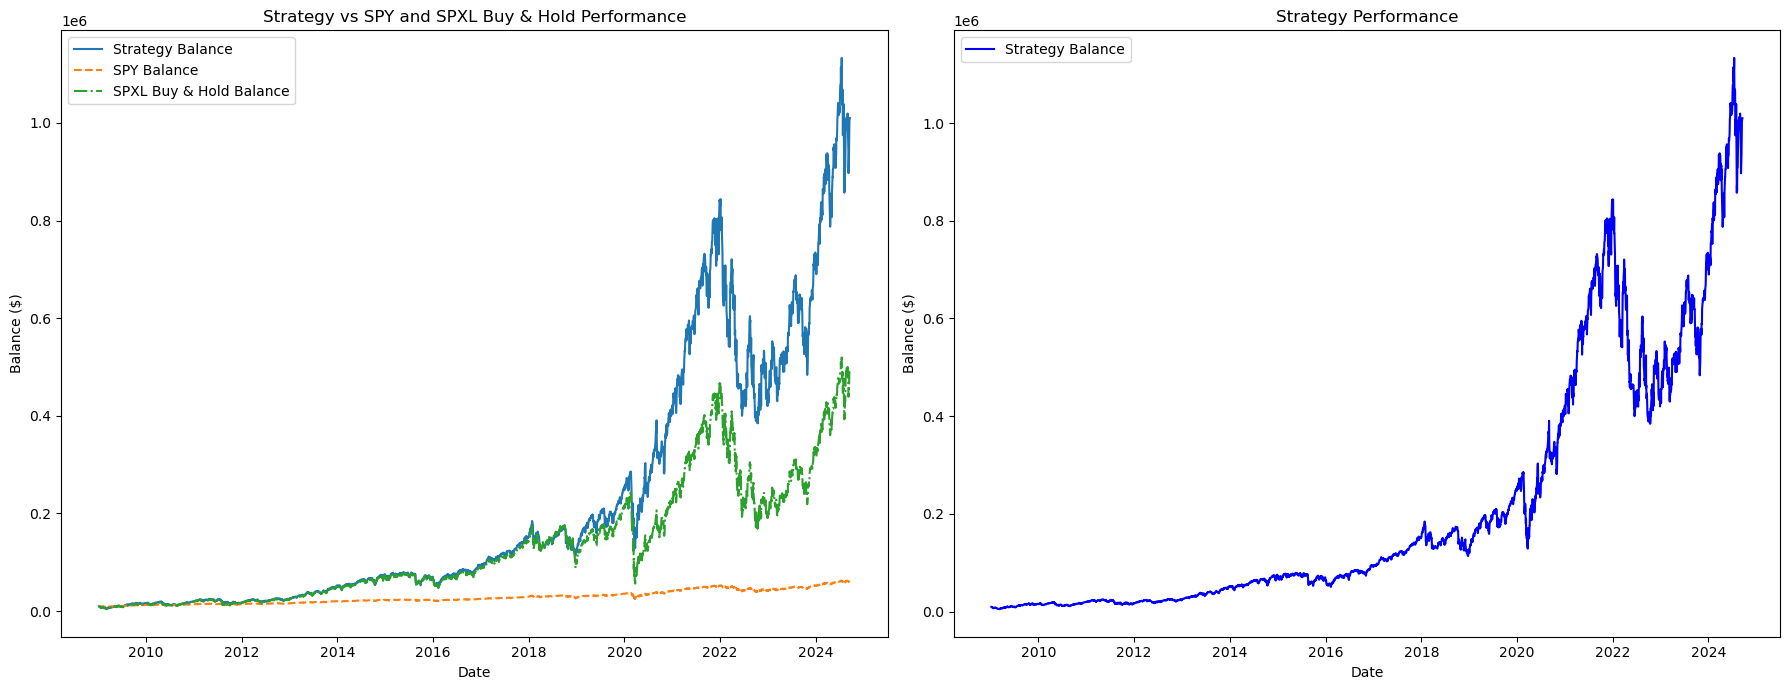

In [39]:
m.backtest_plot()

In [40]:
m.backtest_table()

,Strategy,Starting Principal,Final Balance,Max Drawdown,Sharpe Ratio,Sortino Ratio
0,Custom Strategy,10000,1.009916e+06,-0.548143,0.877646,1.388211
1,SPY Buy & Hold,10000,6.207566e+04,-0.341047,0.739931,NaN
2,SPXL Buy & Hold,10000,4.942797e+05,-0.768561,0.736180,NaN


In [41]:
best_results = m.backtest_best_params()

Best Stop Loss: 0.18
Best Freeze Period: 8
Best Buy Fraction: 0.3999999999999999
Best Sell Fraction: 0.02
Best Trailing Stop Loss: 0.02
Best Trailing Sell Fraction: 0.0
Final Balance: 1009915.646820862
Max Drawdown: -0.5481434649554511
Number of Trades: 5448
Sharpe Ratio: 0.8776456215339346
Sortino Ratio: 1.3882112545174476


In [42]:
trading_strategy = best_results[[0, 1, 2, 3, 4, 5]].to_frame(name = 'Values')

In [43]:
trading_strategy.to_csv('optimal_trading_strategy.csv', index = True)

In [44]:
optimal_trading_strategy = pd.read_csv('optimal_trading_strategy.csv', index_col=0)

In [45]:
optimal_trading_strategy

,Values
Stop Loss,0.18
Freeze Period,8.00
Buy Fraction,0.40
Sell Fraction,0.02
Trailing Stop Loss,0.02
Trailing Sell Fraction,0.00


In [46]:
def real_time_trading(current_signal, current_price, balance, position, freeze_until, buy_fractions, sell_fractions, trailing_stop_loss, trailing_sell_fraction, peak_balance):
    today = datetime.now().strftime('%Y-%m-%d')
    current_balance = balance + (position * current_price)
    trade_details = []
    
    # Check if we are in a freeze period
    if freeze_until:
        try:
            if datetime.strptime(today, '%Y-%m-%d') <= datetime.strptime(freeze_until, '%Y-%m-%d'):
                return balance, position, freeze_until, trade_details, peak_balance
        except (ValueError, TypeError):
            # Skip this section if freeze_until is not in the '%Y-%m-%d' format
            pass


    # Update peak balance for trailing stop-loss
    if current_balance > peak_balance:
        peak_balance = current_balance

    # Check for trailing stop-loss condition
    if current_balance < peak_balance * (1 - trailing_stop_loss):
        shares_to_sell = position * trailing_sell_fraction
        balance += shares_to_sell * current_price
        position -= shares_to_sell
        trade_details.append((today, 'Trailing Stop-Loss', shares_to_sell, current_price))
        print(f"Trailing stop-loss triggered on {today}: Sold {shares_to_sell} shares at {current_price}")

    # Execute buy/sell signals
    if current_signal > 0 and balance > 0:
        amount_to_invest = balance * buy_fractions[current_signal]
        if fractional_shares:
            shares_to_buy = amount_to_invest / spxl_data['Close'].iloc[i]
        else:
            shares_to_buy = amount_to_invest // spxl_data['Close'].iloc[i]
        position += shares_to_buy
        balance -= shares_to_buy * current_price
        trade_details.append((today, 'Buy', shares_to_buy, current_price))
        print(f"Buy signal on {today}: Bought {shares_to_buy} shares at {current_price}")
    elif current_signal < 0 and position > 0:
        shares_to_sell = position * sell_fractions[abs(current_signal)]
        balance += shares_to_sell * current_price
        position -= shares_to_sell
        trade_details.append((today, 'Sell', shares_to_sell, current_price))
        print(f"Sell signal on {today}: Sold {shares_to_sell} shares at {current_price}")

    return balance, position, freeze_until, trade_details

In [47]:
def trade(live_predictions, current_price, positive_quartiles, negative_quartiles, trading_params, trade_history):
    # Calculate the percent changes from each predicted value in the forecast to the current price
    percent_changes = ((live_predictions - current_price) / current_price) * 100
    # Find the mean percent change
    mean_percent_change = percent_changes.mean()

    # Determine the value to store based on the mean percent change:
    # If the mean is positive, find the max value predicted
    # If the mean is negative, find the min value predicted
    if mean_percent_change > 0:
        value = round(percent_changes.max(), 2)
    else:
        value = round(percent_changes.min(), 2)
            
    # Generating a trade signal for strength of buy/sell conviction using the quartiles
    if value > positive_quartiles.loc[0.75][0]:
        signal = 3  # Strong buy
    elif value > positive_quartiles.loc[0.50][0]:
        signal = 2  # Moderate buy
    elif value > positive_quartiles.loc[0.25][0]:
        signal = 1  # Small buy
    elif value > negative_quartiles.loc[0.75][0]:
        signal = 0  # Hold
    elif value > negative_quartiles.loc[0.50][0]:
        signal = -1  # Small sell
    elif value > negative_quartiles.loc[0.25][0]:
        signal = -2  # Moderate sell
    else:
        signal = -3  # Strong sell
    
    # Use the optimal trading parameters
    trading_parameters = {
        'stop_loss_values': trading_params.loc['Stop Loss'][0],
        'freeze_period_values': trading_params.loc['Freeze Period'][0],
        'buy_fraction_values': trading_params.loc['Buy Fraction'][0],
        'sell_fraction_values': trading_params.loc['Sell Fraction'][0],
        'trailing_stop_loss_values': trading_params.loc['Trailing Stop Loss'][0],
        'trailing_sell_fraction_values': trading_params.loc['Trailing Sell Fraction'][0]
    }
    
    # Setting the dynamic buy and sell fractions using the signal strength as a weight
    buy_fraction = trading_parameters['buy_fraction_values']
    sell_fraction = trading_parameters['sell_fraction_values']
    buy_fractions = {1: buy_fraction * 0.5, 2: buy_fraction, 3: buy_fraction * 1.5}
    sell_fractions = {1: sell_fraction * 0.5, 2: sell_fraction, 3: sell_fraction * 1.5}
    
    # Extracting the necessary variables from the trade history csv file
    peak_balance = trade_history['balance'].max()
    balance = trade_history['balance'][-1]
    position = trade_history['position'][-1]
    freeze_until = trade_history['freeze_until'][-1]
    trailing_stop_loss = trading_parameters['trailing_stop_loss_values']
    trailing_sell_fraction = trading_parameters['trailing_sell_fraction_values']
    
    # Retrieve the current price of SPXL (Since we train on SPY, but trade on SPXL
    SPXL_price = yf.Ticker("SPXL").history(period="1d")['Close'][0]
    
    balance, position, freeze_until, trade_details = real_time_trading(signal, SPXL_price, balance, position, freeze_until, buy_fractions, sell_fractions, trailing_stop_loss, trailing_sell_fraction, peak_balance)
    
    # variables stored as a dict
    data_dict = {
        'balance': balance,
        'position': position,
        'freeze_until': freeze_until,
        'trade_details': trade_details
    }

    return data_dict

In [48]:
def update_and_validate(trade_history):
    # Creating a check variable to see if we need to add a trade for today
    new_trade = True
    today = datetime.now().strftime('%Y-%m-%d')
    
    # Trim the date string and convert to datetime if it is not already in that format
    if not isinstance(trade_history.index, pd.DatetimeIndex):
        trade_history.index = pd.to_datetime(trade_history.index.str[:10], format='%Y-%m-%d', errors='coerce')
    
    # Convert the index to string for comparison 
    trade_history_index_str = trade_history.index.strftime('%Y-%m-%d')
    
    # Check if the DataFrame has today's date as an index -- if so, a trade has already been made
    if today in trade_history_index_str:
        new_trade = False
        
    # Drop rows that are filled with NaN
    trade_history.dropna(how='all', inplace=True)

    # Drop rows where index conversion resulted in NaT
    trade_history = trade_history[trade_history.index.notna()]

    if new_trade:
        # Retrieve the last date in the DataFrame
        last_date = trade_history.index[-1].strftime('%Y-%m-%d')
        start_date = (pd.to_datetime(last_date) + timedelta(1)).strftime('%Y-%m-%d')

        # Get the NYSE trading calendar
        nyse = mcal.get_calendar('NYSE')
        trading_days = nyse.valid_days(start_date=start_date, end_date=today)

        # Fetch SPXL data for missing dates
        spxl_data = yf.download(trading_ticker, start=start_date, progress=False)

        # Convert spxl_data index to string format for comparison
        spxl_data.index = spxl_data.index.strftime('%Y-%m-%d')

        # Generate new rows for missing dates
        for date in trading_days:
            date_str = date.strftime('%Y-%m-%d')
            if date_str not in trade_history_index_str:
                price_on_date = spxl_data.loc[date_str]['Close'] if date_str in spxl_data.index else 'NaN'
                new_row = {
                    'balance': trade_history['balance'].iloc[-1],
                    'position': trade_history['position'].iloc[-1],
                    'freeze_until': trade_history['freeze_until'].iloc[-1],
                    'trade_details': f"('{date_str}', 'NaN', 0.0, {price_on_date})"
                }
                trade_history.loc[date_str] = new_row

        # Convert the new index to datetime again to ensure consistency
        trade_history.index = pd.to_datetime(trade_history.index)

        # Sort the index
        trade_history.sort_index(inplace=True)

    # Fetch SPXL data for the entire date range in the DataFrame
    spxl_data_full = yf.download(trading_ticker, start=trade_history.index.min().strftime('%Y-%m-%d'), progress=False)
    spxl_data_full.index = spxl_data_full.index.strftime('%Y-%m-%d')

    # Add 'total_portfolio' column if one does not already exist
    if 'total_portfolio' not in trade_history.columns:
        trade_history['total_portfolio'] = trade_history.apply(
            lambda row: row['balance'] + (row['position'] * spxl_data_full.loc[row.name.strftime('%Y-%m-%d')]['Close']), axis=1
        )

    return trade_history, new_trade


In [49]:
# Read the trade history df in:
trade_history = pd.read_csv('trade_history.csv', index_col=0, parse_dates=True)

In [50]:
optimal_trading_strategy = pd.read_csv('optimal_trading_strategy.csv', index_col=0)

In [51]:
trade_history

,balance,position,freeze_until,trade_details,total_portfolio
2024-10-30,1000.000000,0.0,NaN,NaN,1000.000000
2024-10-31,681.600189,2.0,NaN,"('2024-10-31', 'Buy', 2.0, 159.1999053955078)",996.260193
2024-11-01,681.600189,2.0,NaN,"('2024-11-01', 'NaN', 0.0, 159.17999267578125)",999.960175
2024-11-02,363.240204,4.0,NaN,"('2024-11-02', 'Buy', 2.0, 159.17999267578125)",NaN


In [52]:
trade_history, new_trade_flag = update_and_validate(trade_history)

In [53]:
if new_trade_flag:
    trade_results = trade(m.p, m.last_known_price, m.positive_quartiles, m.negative_quartiles, optimal_trading_strategy, trade_history)

    # Check if trade_results is not empty
    if trade_results:
        trade_results_df = pd.DataFrame(trade_results, index=[datetime.now().strftime('%Y-%m-%d')])
        trade_history = pd.concat([trade_history, trade_results_df])
        trade_history.to_csv('trade_history.csv')
    else:
        print("No trade results generated.")

ValueError: Length of values (0) does not match length of index (1)

In [ ]:
display(trade_history)